# 1. Data Sources & Collection

CMS Nursing Home Provider Information - https://data.cms.gov/provider-data/dataset/4pq5-n9py (2017 - 2021)

CMS Medicare Claims Quality Measures - https://data.cms.gov/provider-data/dataset/ijh5-nb2v (April 2020 - March 2021)

CMS Survey Summary - https://data.cms.gov/provider-data/dataset/tbry-pc2d (2017 - 2020)

CMS MDS Quality Measures - https://data.cms.gov/provider-data/dataset/djen-97ju (April 2020 - March 2021)

CMS COVID-19 Nursing Home Data - https://data.cms.gov/covid-19/covid-19-nursing-home-data (April 2020 - December 2020, January 2021 - March 2021)

# 2. Construct dataset

In [105]:
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

In [106]:
# Set directory
os.chdir('C:/Users/erpin/Documents/CIND820')

In [107]:
p = 'NH_ProviderInfo_Jan2022.csv'
s = 'NH_SurveySummary_Nov2021.csv'
m = 'NH_QualityMsr_MDS_Nov2021.csv'
c = 'NH_QualityMsr_Claims_Nov2021.csv'
cov = 'faclevel_2020.csv'

# Select columns from provider dataset
dfp = pd.read_csv(p, dtype={'Federal Provider Number':'str'}, encoding='cp1252')
colsp= [0,1,4,9,10,11,30,48,50,58,59,60,87,88,89]
dfp = dfp[dfp.columns[colsp]]
dfp['Federal Provider Number'] = dfp['Federal Provider Number'].apply(lambda x: x.lstrip('0'))

# Select columns from MDS dataset 
dfm = pd.read_csv(m, dtype={'Federal Provider Number':'str'}, encoding='cp1252')
LS = dfm[dfm['Resident type']== 'Long Stay']
colsm = [0,7,8,17]
LS = LS[LS.columns[colsm]]
LSpivot = LS.pivot(index=['Federal Provider Number', 'Resident type'], columns='Measure Description', values='Four Quarter Average Score')
LSpivot.reset_index(drop=False, inplace=True)
LSpivot['Federal Provider Number'] = LSpivot['Federal Provider Number'].apply(lambda x: x.lstrip('0'))

# Select columns from surveys dataset 
dfs = pd.read_csv(s, dtype={'Federal Provider Number':'str'}, encoding='cp1252')
colss = [0,6,7,9,10]
dfs = dfs[dfs.columns[colss]]
dfs = dfs[dfs['Inspection Cycle']==3]
dfs.to_csv('inspection.csv')
dfs['Federal Provider Number'] = dfs['Federal Provider Number'].apply(lambda x: x.lstrip('0'))

#select columns from COVID 2020 dataset 
dfcov = pd.read_csv(cov, dtype={'Federal Provider Number':'str'})
colcov = [1,13,19,22]
dfcov = dfcov[dfcov.columns[colcov]]
dfcov['Total Number of Occupied Beds'] = dfcov['Total Number of Occupied Beds'].replace(0, np.nan)
dfcov['Confirmed COVID-19 Cases Per Occupied Beds'] = dfcov['Residents Weekly Confirmed COVID-19']/dfcov['Total Number of Occupied Beds']
dfcov['COVID-19 Deaths Per Occupied Beds'] = dfcov['Residents Weekly COVID-19 Deaths']/dfcov['Total Number of Occupied Beds']
dfcovm = dfcov.groupby(['Federal Provider Number']).mean().reset_index()
dfcovm['Federal Provider Number'] = dfcovm['Federal Provider Number'].apply(lambda x: x.lstrip('0'))

#Select columns from claims dataset 
dfc = pd.read_csv(c, dtype={'Federal Provider Number':'str'}, encoding='cp1252')
dfc = dfc[dfc['Measure Description']=='Number of outpatient emergency department visits per 1000 long-stay resident days']
colc = [0,7,9]
dfc = dfc[dfc.columns[colc]]
dfc['Federal Provider Number'] = dfc['Federal Provider Number'].apply(lambda x: x.lstrip('0'))

df1 = pd.merge(dfp, LSpivot, on='Federal Provider Number', how='left')
df2 = pd.merge(df1, dfs, on='Federal Provider Number', how='left')
df3 = pd.merge(df2, dfcovm, on='Federal Provider Number', how='left')
final_df = pd.merge(df3, dfc, on='Federal Provider Number', how='left')

C:\Users\erpin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (84,85) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [108]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 3. Data Cleaning

In [109]:
#Checking columns 
final_df.columns.tolist()

['Federal Provider Number',
 'Provider Name',
 'Provider State',
 'Ownership Type',
 'Number of Certified Beds',
 'Average Number of Residents per Day',
 'Long-Stay QM Rating',
 'Total nursing staff turnover',
 'Registered Nurse turnover',
 'Adjusted Nurse Aide Staffing Hours per Resident per Day',
 'Adjusted LPN Staffing Hours per Resident per Day',
 'Adjusted RN Staffing Hours per Resident per Day',
 'Number of Facility Reported Incidents',
 'Number of Substantiated Complaints',
 'Number of Citations from Infection Control Inspections',
 'Resident type',
 'Percentage of high risk long-stay residents with pressure ulcers',
 'Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine',
 'Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine',
 'Percentage of long-stay residents experiencing one or more falls with major injury',
 'Percentage of long-stay residents who have depressive symptoms',
 'Percentage of 

In [110]:
# Rename 'Adjusted Score' to 'Number of outpatient emergency department visits per 1000 long-stay resident days'
final_df.rename(columns={'Adjusted Score': 'Number of outpatient emergency department visits per 1000 long-stay resident days'}, inplace=True)

In [111]:
#Remove unnecessary columns - Resident type, Inspection Cycle, Measure Description, Residents Weekly Confirmed COVID-19, Residents Weekly COVID-19 Deaths, Total Number of Occupied Beds
final_df.drop(['Resident type', 'Inspection Cycle', 'Measure Description', 'Residents Weekly Confirmed COVID-19', 'Residents Weekly COVID-19 Deaths', 'Total Number of Occupied Beds', 'Health Survey Date', 'Provider State'], axis=1, inplace=True)

In [112]:
# Count number of rows - 15238 
len(final_df.index)

15238

In [113]:
#Check for duplicate rows - No duplicates 
final_df[final_df['Federal Provider Number'].duplicated() == True].sort_values('Federal Provider Number')

Empty DataFrame
Columns: [Federal Provider Number, Provider Name, Ownership Type, Number of Certified Beds, Average Number of Residents per Day, Long-Stay QM Rating, Total nursing staff turnover, Registered Nurse turnover, Adjusted Nurse Aide Staffing Hours per Resident per Day, Adjusted LPN Staffing Hours per Resident per Day, Adjusted RN Staffing Hours per Resident per Day, Number of Facility Reported Incidents, Number of Substantiated Complaints, Number of Citations from Infection Control Inspections, Percentage of high risk long-stay residents with pressure ulcers, Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine, Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine, Percentage of long-stay residents experiencing one or more falls with major injury, Percentage of long-stay residents who have depressive symptoms, Percentage of long-stay residents who lose too much weight, Percentage of long-stay residents who received an antianxiety or hypnotic medication, Percentage of long-stay residents who received an antipsychotic medication, Percentage of long-stay residents who were physically restrained, Percentage of long-stay residents whose ability to move independently worsened, Percentage of long-stay residents whose need for help with daily activities has increased, Percentage of long-stay residents with a catheter inserted and left in their bladder, Percentage of long-stay residents with a urinary tract infection, Percentage of low risk long-stay residents who lose control of their bowels or bladder, Total Number of Health Deficiencies, Total Number of Fire Safety Deficiencies, Confirmed COVID-19 Cases Per Occupied Beds, COVID-19 Deaths Per Occupied Beds, Number of outpatient emergency department visits per 1000 long-stay resident days]
Index: []

[0 rows x 33 columns]

In [114]:
#Check for null values in dependent value - 2241 rows
final_df['Number of outpatient emergency department visits per 1000 long-stay resident days'].isna().sum()
#Remove 2241 rows with null dependent value 
mod_df = final_df.dropna(how='any', subset=['Number of outpatient emergency department visits per 1000 long-stay resident days'])

In [115]:
#Nulls per column 
colnulls = mod_df.isnull().sum(axis=0).to_frame(name='Column Nulls')

In [116]:
#Nulls per column 
colnulls = mod_df.isnull().sum(axis=0).to_frame(name='Column Nulls')
# Count nulls per row 
rownulls = mod_df.set_index('Provider Name').isnull().sum(axis=1)
rownulls.count()
rownulls[rownulls > 15].count()
rownulls.sort_values(ascending=False)

Provider Name
HEDDINGTON OAKS                                      20
GOLDEN CROSS HEALTH CARE                             20
GREENE COUNTY NURSING HOME                           20
THE VILLAGES OF GENERAL BAPTIST HEALTH CARE  EAST    20
ROLLING MEADOWS                                      17
                                                     ..
HARROGATE                                             0
LAKELAND HEALTH CARE CENTER                           0
ASPEN HILLS HEALTHCARE CENTER                         0
PROMEDICA SKILLED NURSING & REHAB - MOUNTAINSIDE      0
LIFE CARE CENTER OF SULLIVAN                          0
Length: 12997, dtype: int64

In [117]:
# Coding the 'Ownership' Categorical Variable in prepartion for dummy variable creation
mod_df['Ownership Type'].value_counts()
categorizing_ownership = {'Ownership Type': {
    'For profit - Corporation': 1, 
    'Non profit - Corporation': 0,
    'For profit - Limited Liability company': 1,
    'For profit - Individual': 1, 
    'For profit - Partnership': 1,
    'Government - County': 2,
    'Non profit - Church related': 0,
    'Non profit - Other': 0, 
    'Government - Hospital district': 2, 
    'Government - State': 2,
    'Government - City': 2, 
    'Government - City/county': 2,
    'Government - Federal': 2}}
mod_df = mod_df.replace(categorizing_ownership)
mod_df.head()

Federal Provider Number                                Provider Name  \
0                   15009                     BURNS NURSING HOME, INC.   
1                   15010               COOSA VALLEY HEALTHCARE CENTER   
2                   15012                   HIGHLANDS HEALTH AND REHAB   
3                   15014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                   15015                PLANTATION MANOR NURSING HOME   

   Ownership Type  Number of Certified Beds  \
0               1                        57   
1               1                        85   
2               2                        50   
3               1                        92   
4               1                       103   

   Average Number of Residents per Day  Long-Stay QM Rating  \
0                                 53.2                  5.0   
1                                 79.8                  2.0   
2                                 39.9                  3.0   
3                                 69.4                  2.0   
4                                 72.4                  3.0   

   Total nursing staff turnover  Registered Nurse turnover  \
0                           NaN                        NaN   
1                          52.4                       21.4   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                          51.3                       60.0   

   Adjusted Nurse Aide Staffing Hours per Resident per Day  \
0                                                NaN         
1                                            2.49541         
2                                                NaN         
3                                            2.02560         
4                                            2.36250         

   Adjusted LPN Staffing Hours per Resident per Day  ...  \
0                                               NaN  ...   
1                                           0.83163  ...   
2                                               NaN  ...   
3                                           0.98558  ...   
4                                           1.28006  ...   

   Percentage of long-stay residents whose ability to move independently worsened  \
0                                          28.180706                                
1                                          14.764966                                
2                                          31.351583                                
3                                          36.218930                                
4                                          10.404354                                

   Percentage of long-stay residents whose need for help with daily activities has increased  \
0                                          15.060243                                           
1                                           8.837209                                           
2                                          12.500002                                           
3                                          21.198155                                           
4                                          10.599077                                           

   Percentage of long-stay residents with a catheter inserted and left in their bladder  \
0                                           0.738709                                      
1                                           2.067165                                      
2                                           4.839041                                      
3                                           2.700401                                      
4                                           0.560731                                      

   Percentage of long-stay residents with a urinary tract infection  \
0                                           0.555555                  
1          

In [252]:
#Create dummy variables and drop first to avoid dummy variable trap 
clean_df = pd.get_dummies(mod_df, columns=['Ownership Type', 'Long-Stay QM Rating'], drop_first=True)
clean_df.head()

Federal Provider Number                                Provider Name  \
0                   15009                     BURNS NURSING HOME, INC.   
1                   15010               COOSA VALLEY HEALTHCARE CENTER   
2                   15012                   HIGHLANDS HEALTH AND REHAB   
3                   15014  EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                   15015                PLANTATION MANOR NURSING HOME   

   Number of Certified Beds  Average Number of Residents per Day  \
0                        57                                 53.2   
1                        85                                 79.8   
2                        50                                 39.9   
3                        92                                 69.4   
4                       103                                 72.4   

   Total nursing staff turnover  Registered Nurse turnover  \
0                           NaN                        NaN   
1                          52.4                       21.4   
2                           NaN                        NaN   
3                           NaN                        NaN   
4                          51.3                       60.0   

   Adjusted Nurse Aide Staffing Hours per Resident per Day  \
0                                                NaN         
1                                            2.49541         
2                                                NaN         
3                                            2.02560         
4                                            2.36250         

   Adjusted LPN Staffing Hours per Resident per Day  \
0                                               NaN   
1                                           0.83163   
2                                               NaN   
3                                           0.98558   
4                                           1.28006   

   Adjusted RN Staffing Hours per Resident per Day  \
0                                              NaN   
1                                          1.17810   
2                                              NaN   
3                                          0.53602   
4                                          0.50438   

   Number of Facility Reported Incidents  ...  \
0                                      0  ...   
1                                      0  ...   
2                                      0  ...   
3                                      0  ...   
4                                      0  ...   

   Total Number of Fire Safety Deficiencies  \
0                                       2.0   
1                                       3.0   
2                                       0.0   
3                                       5.0   
4                                       4.0   

   Confirmed COVID-19 Cases Per Occupied Beds  \
0                                    0.032987   
1                                    0.008493   
2                                    0.009605   
3                                    0.014678   
4                                    0.004360   

   COVID-19 Deaths Per Occupied Beds  \
0                           0.003443   
1                           0.000963   
2                           0.003024   
3                           0.000000   
4                           0.000000   

   Number of outpatient emergency department visits per 1000 long-stay resident days  \
0                                           0.272998                                   
1                                           0.481088                                   
2                                           0.988491                                   
3                                           0.866367                                   
4                                           0.640404                                   

   Ownership Type_1  Ownership Type_2  Long-Stay QM Rating_2.0  \
0                 1                 0

In [338]:
#Reindexing 
column_names = ['Federal Provider Number', 'Provider Name', 'Number of Certified Beds',
       'Average Number of Residents per Day', 'Total nursing staff turnover',
       'Registered Nurse turnover',
       'Adjusted Nurse Aide Staffing Hours per Resident per Day',
       'Adjusted LPN Staffing Hours per Resident per Day',
       'Adjusted RN Staffing Hours per Resident per Day',
       'Number of Facility Reported Incidents',
       'Number of Substantiated Complaints',
       'Number of Citations from Infection Control Inspections',
       'Percentage of high risk long-stay residents with pressure ulcers',
       'Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine',
       'Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine',
       'Percentage of long-stay residents experiencing one or more falls with major injury',
       'Percentage of long-stay residents who have depressive symptoms',
       'Percentage of long-stay residents who lose too much weight',
       'Percentage of long-stay residents who received an antianxiety or hypnotic medication',
       'Percentage of long-stay residents who received an antipsychotic medication',
       'Percentage of long-stay residents who were physically restrained',
       'Percentage of long-stay residents whose ability to move independently worsened',
       'Percentage of long-stay residents whose need for help with daily activities has increased',
       'Percentage of long-stay residents with a catheter inserted and left in their bladder',
       'Percentage of long-stay residents with a urinary tract infection',
       'Percentage of low risk long-stay residents who lose control of their bowels or bladder',
       'Total Number of Health Deficiencies',
       'Total Number of Fire Safety Deficiencies',
       'Confirmed COVID-19 Cases Per Occupied Beds',
       'COVID-19 Deaths Per Occupied Beds',
       'Ownership Type_1', 'Ownership Type_2', 'Long-Stay QM Rating_2.0',
       'Long-Stay QM Rating_3.0', 'Long-Stay QM Rating_4.0',
       'Long-Stay QM Rating_5.0', 'Number of outpatient emergency department visits per 1000 long-stay resident days']
clean_df = clean_df.reindex(columns=column_names)
clean_df

Federal Provider Number                                   Provider Name  \
0                       15009                        BURNS NURSING HOME, INC.   
1                       15010                  COOSA VALLEY HEALTHCARE CENTER   
2                       15012                      HIGHLANDS HEALTH AND REHAB   
3                       15014     EASTVIEW REHABILITATION & HEALTHCARE CENTER   
4                       15015                   PLANTATION MANOR NURSING HOME   
...                       ...                                             ...   
15216                  676481                           BETHANY SENIOR LIVING   
15217                  676482                CYPRESS POINTE HEALTH & WELLNESS   
15225                  676491            MISSION RIDGE REHAB & NURSING CENTER   
15234                  686123  KENDALL LAKES HEALTH AND REHABILITATION CENTER   
15235                  686124                           HARMONY HEALTH CENTER   

       Number of Certified Beds  Average Number of Residents per Day  \
0                            57                                 53.2   
1                            85                                 79.8   
2                            50                                 39.9   
3                            92                                 69.4   
4                           103                                 72.4   
...                         ...                                  ...   
15216                       130                                109.5   
15217                       124                                 89.5   
15225                        90                                 47.6   
15234                       150                                145.8   
15235                       203                                178.5   

       Total nursing staff turnover  Registered Nurse turnover  \
0                               NaN                        NaN   
1                              52.4                       21.4   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                              51.3                       60.0   
...                             ...                        ...   
15216                           NaN                        NaN   
15217                          32.6                       40.0   
15225                           NaN                        NaN   
15234                           NaN                        NaN   
15235                          36.4                       45.2   

       Adjusted Nurse Aide Staffing Hours per Resident per Day  \
0                                                    NaN         
1                                                2.49541         
2                                                    NaN         
3                                                2.02560         
4                                                2.36250         
...                                                  ...         
15216                                                NaN         
15217                                            1.68197         
15225                                                NaN         
15234                                            2.36888         
15235                                            2.54577         

       Adjusted LPN Staffing Hours per Resident per Day  \
0                                                   NaN   
1                                               0.83163   
2                                                   NaN   
3                                               0.98558   
4                                               1.28006   
...                                                 ...   
15216                                               NaN   
15217                                           0.82898   
15225                                              

# 4.Data Exploration & Pre-processing

In [339]:
#Dataset shape
clean_df.shape

(12997, 37)

In [340]:
#Dataset info 
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12997 entries, 0 to 15235
Data columns (total 37 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   Federal Provider Number                                                                            12997 non-null  object 
 1   Provider Name                                                                                      12997 non-null  object 
 2   Number of Certified Beds                                                                           12997 non-null  int64  
 3   Average Number of Residents per Day                                                                12973 non-null  float64
 4   Total nursing staff turnover                                                                       11052 non-null  flo

Both Total nursing staff turnover and Registered Nurse turnover attributes have a large, but acceptable number of nulls from 1000-2000 rows. 

In [341]:
#Describe dataset 
clean_df.describe()
# .to_csv("DescribeDataset.csv")

Number of Certified Beds  Average Number of Residents per Day  \
count              12997.000000                         12973.000000   
mean                 113.143649                            81.455230   
std                   59.809910                            46.666475   
min                   18.000000                             1.000000   
25%                   74.000000                            51.000000   
50%                  104.000000                            73.700000   
75%                  132.000000                            99.300000   
max                  874.000000                           703.300000   

       Total nursing staff turnover  Registered Nurse turnover  \
count                  11052.000000               10350.000000   
mean                      51.273127                  49.536705   
std                       15.068248                  21.247156   
min                        6.100000                   0.000000   
25%                       40.900000                  33.300000   
50%                       50.700000                  50.000000   
75%                       60.900000                  64.000000   
max                      100.000000                 100.000000   

       Adjusted Nurse Aide Staffing Hours per Resident per Day  \
count                                       12645.000000         
mean                                            2.171593         
std                                             0.584521         
min                                             0.000000         
25%                                             1.788230         
50%                                             2.110130         
75%                                             2.495520         
max                                             6.903020         

       Adjusted LPN Staffing Hours per Resident per Day  \
count                                      12645.000000   
mean                                           0.870455   
std                                            0.339521   
min                                            0.000000   
25%                                            0.648650   
50%                                            0.853320   
75%                                            1.073060   
max                                            3.636150   

       Adjusted RN Staffing Hours per Resident per Day  \
count                                     12645.000000   
mean                                          0.675686   
std                                           0.403360   
min                                           0.000000   
25%                                           0.400500   
50%                                           0.585050   
75%                                           0.855110   
max                                           5.580270   

       Number of Facility Reported Incidents  \
count                           12997.000000   
mean                                1.539432   
std                                 3.578529   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 2.000000   
max                                72.000000   

       Number of Substantiated Complaints  \
count                        12997.000000   
mean                             4.832808   
std                              9.157541   
min                              0.000000   
25%                              0.000000   
50%                              2.000000   
75%                              5.000000   
max                            162.000000   

       Number of Citations from Infection Control Inspections  ...  \
count                                       12993.000000       ...   
mean                                            1.357269       ...   
std                                             2.368291       .

## Distributions

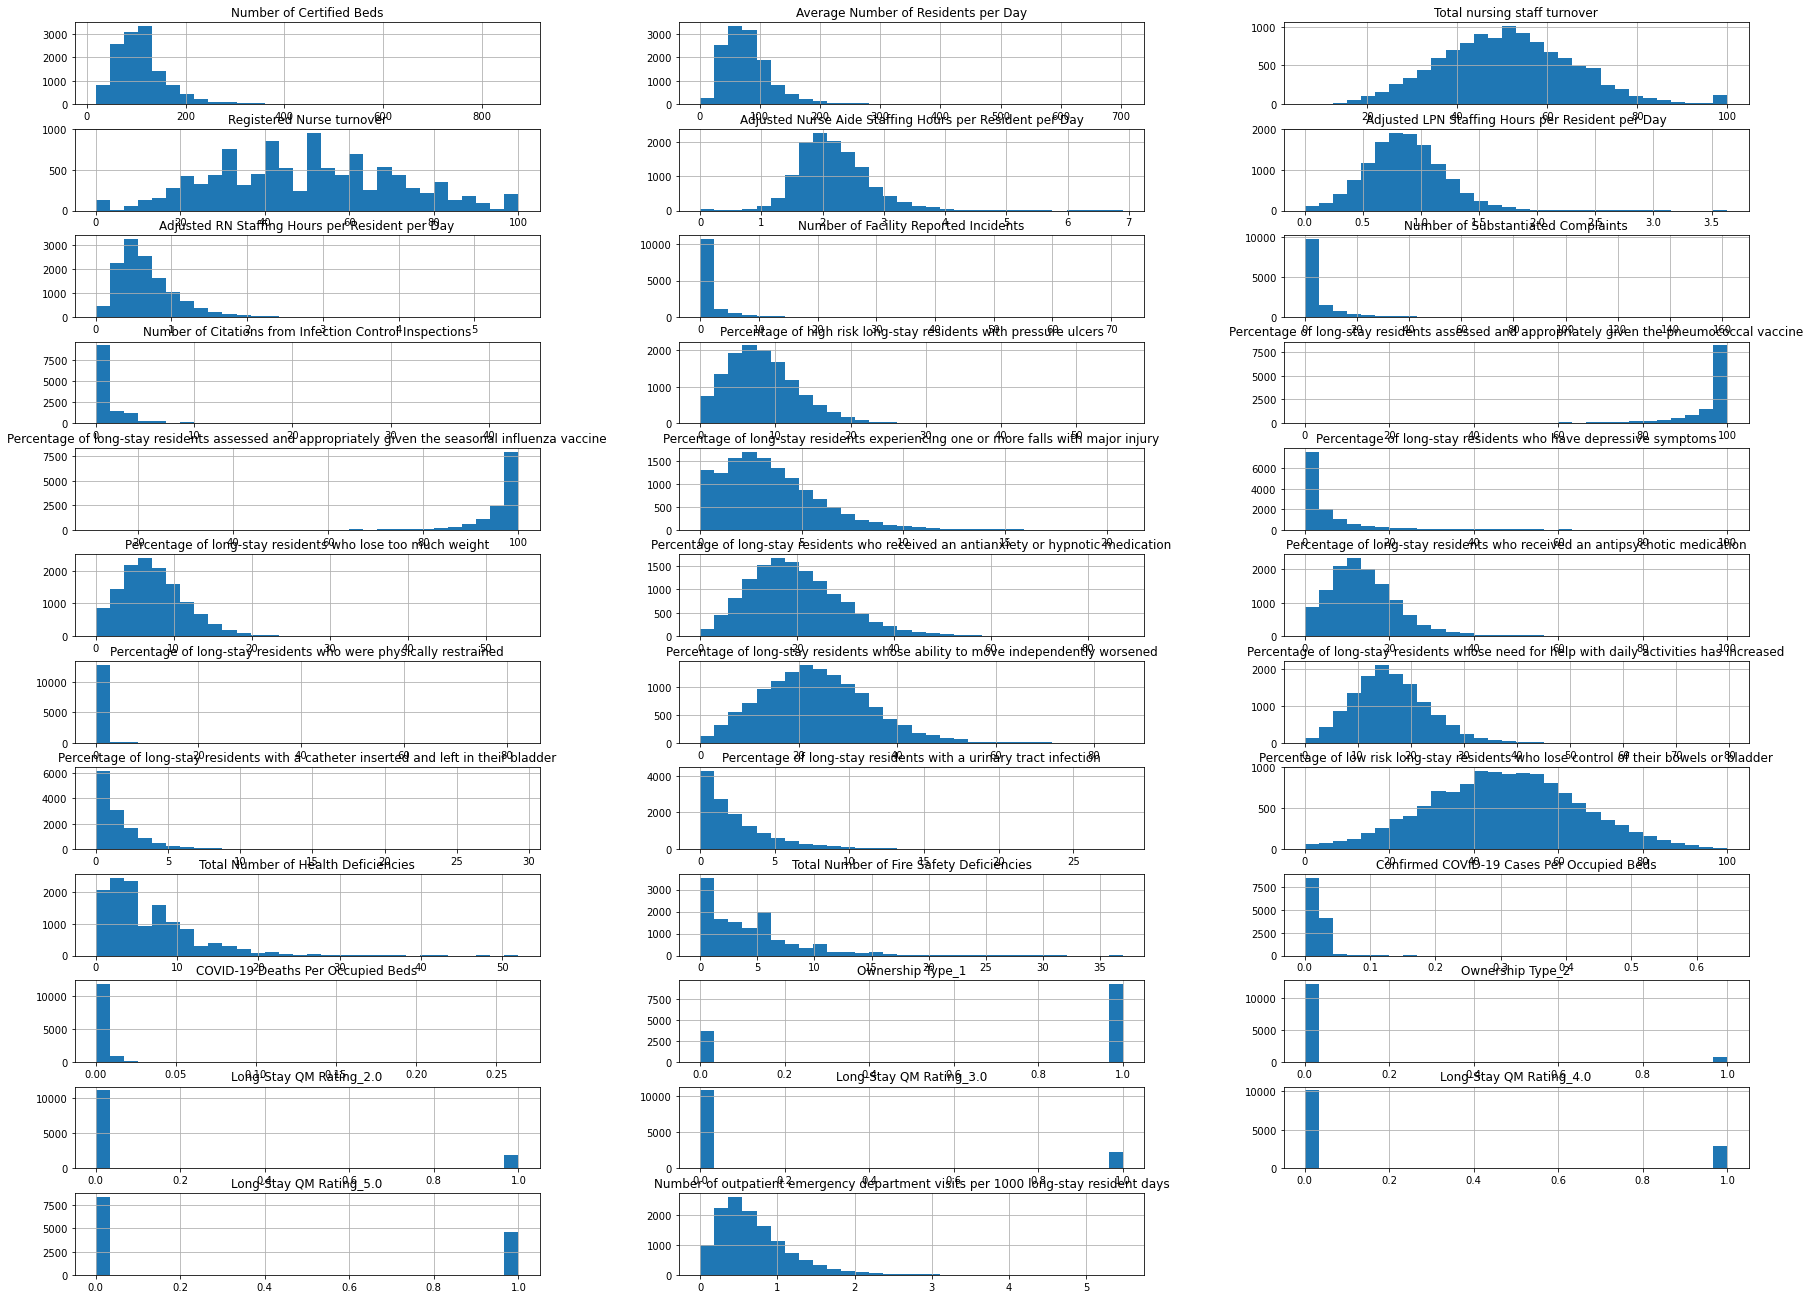

In [342]:
# Visualize distributions
clean_df.hist(bins=30, figsize=(30,25), layout=(13,3));

On visual inspection, it can be noted that ~15 plots are approximately normally distributed, however a number of attributes are not normally distributed or have notably long right- or left-tails, including the dependent variable. This will be further addressed in assumption testing.

## Outlier Detection

Since the data was manually reported by nursing homes regarding their performance, a cautious approach will be taken for outlier detection and removal. 

<ipython-input-343-e1c281880675>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


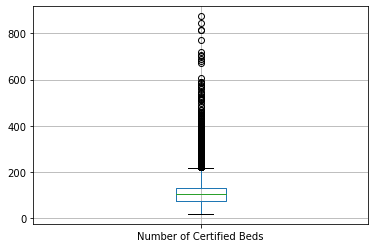

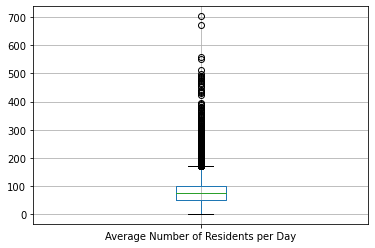

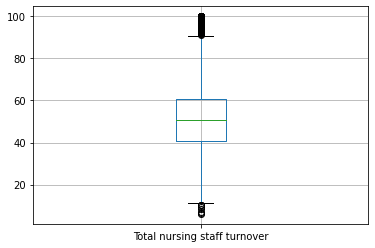

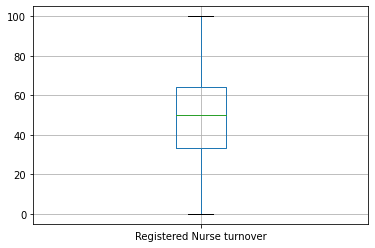

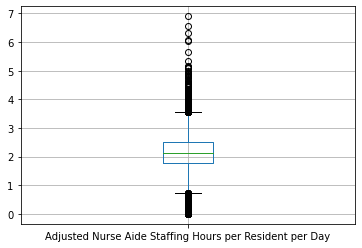

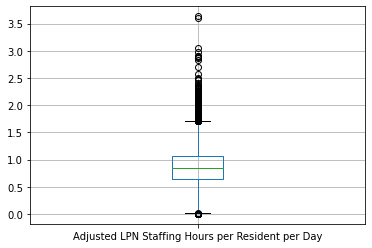

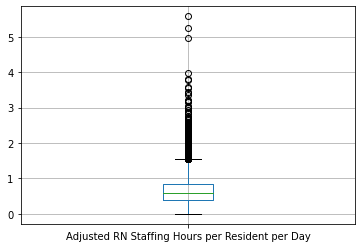

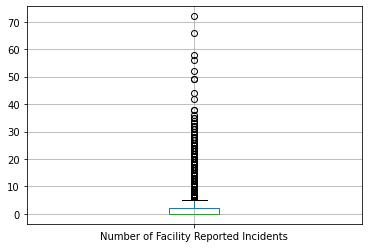

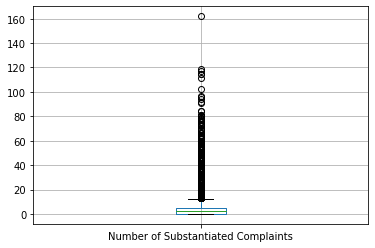

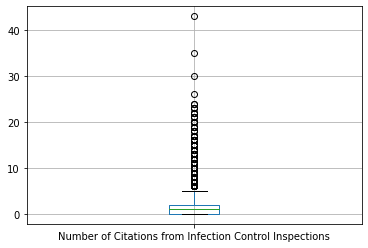

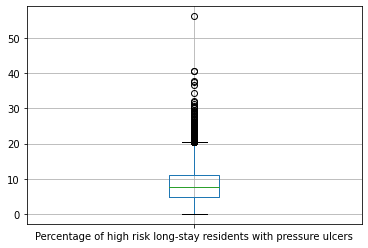

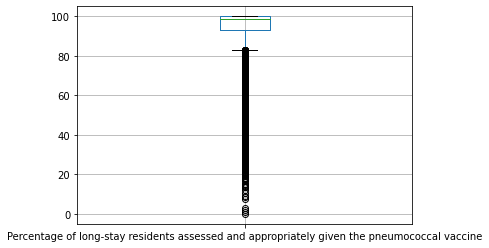

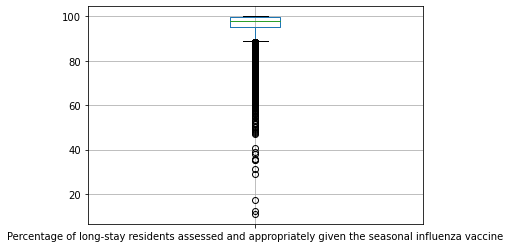

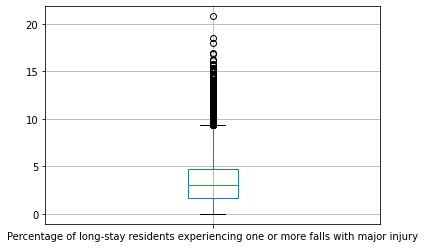

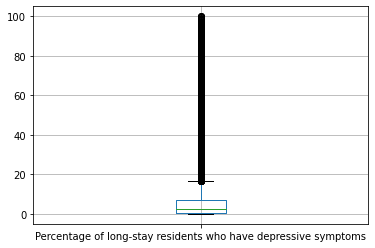

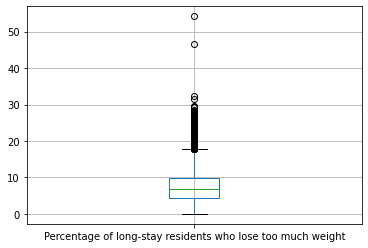

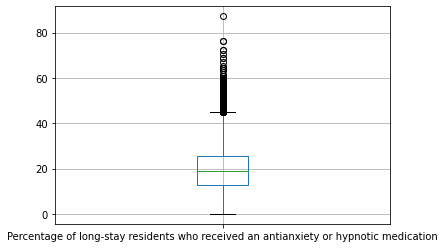

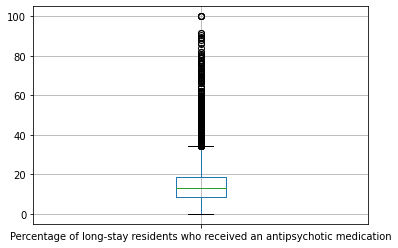

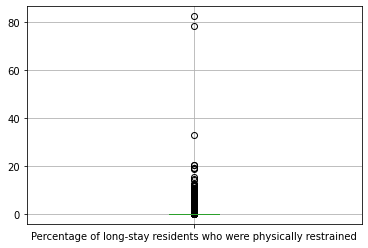

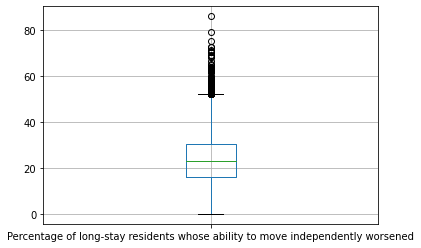

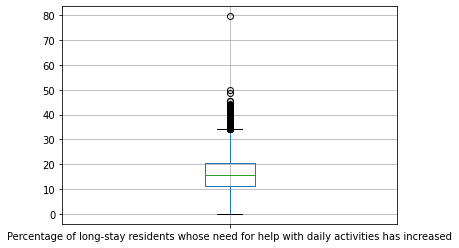

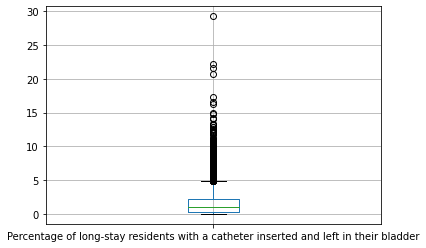

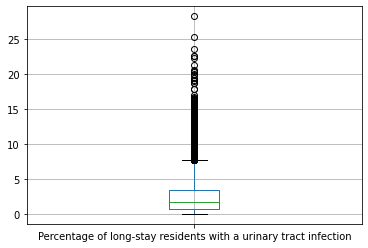

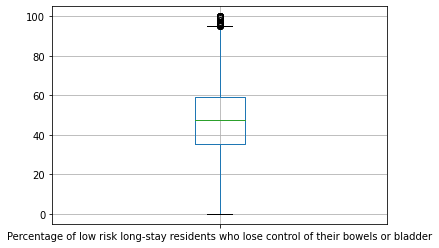

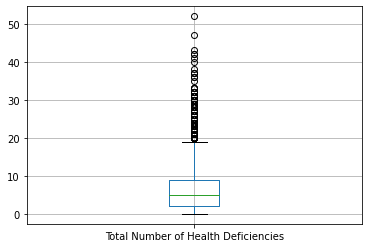

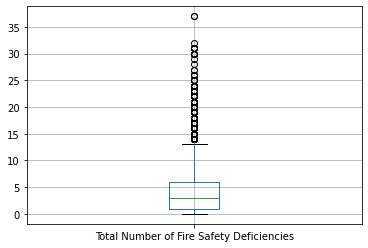

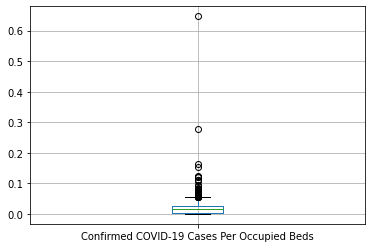

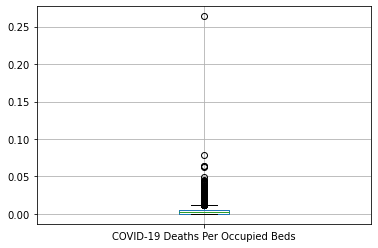

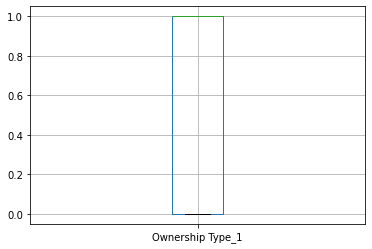

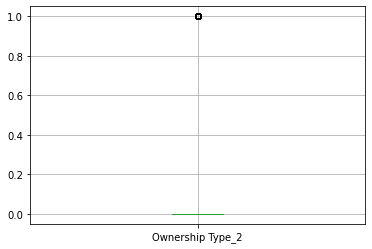

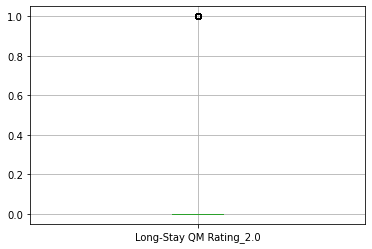

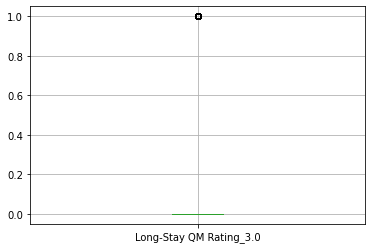

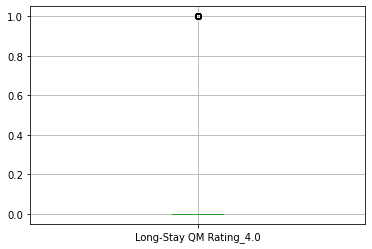

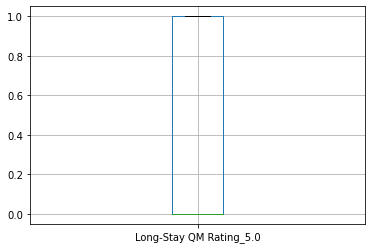

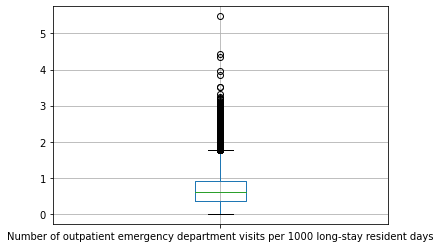

In [343]:
#Visualizing outliers 
outlier_df = clean_df.drop(['Federal Provider Number', 'Provider Name'], axis=1).copy()
for i in outlier_df:
    plt.figure()
    outlier_df.boxplot([i])

On visual analysis, there are a varying amount of outliers in each attribute, however the majority of attributes have outliers on one-tail, resulting in skew. To quantify this, the skewness will be calculated below:

In [344]:
#Evaluating skewness of attributes 
outlier_df.skew()

Number of Certified Beds                                                                              2.814405
Average Number of Residents per Day                                                                   2.784565
Total nursing staff turnover                                                                          0.356678
Registered Nurse turnover                                                                             0.149541
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.709330
Adjusted LPN Staffing Hours per Resident per Day                                                      0.584469
Adjusted RN Staffing Hours per Resident per Day                                                       1.922657
Number of Facility Reported Incidents                                                                 5.765617
Number of Substantiated Complaints                                                                    4.545777
N

There is a significant amount of skew in 9 numeric attributes. To address this, right-skewed attributes values with a skew > 3 greater will have values greater than the 99th percentile replaced by the median. Left-skewed values with a skew < -3 will have values less than the 1st percentile replaced by the median. Categorical dummy variables will not be included.

In [345]:
#Addressing skew and testing resulting skewness 
Q1 = outlier_df.quantile(0.01)
Q50 = outlier_df.quantile(0.5)
Q99 = outlier_df.quantile(0.99)
outlier_df['Number of Facility Reported Incidents'] = np.where(outlier_df['Number of Facility Reported Incidents'] > Q99['Number of Facility Reported Incidents'], Q50['Number of Facility Reported Incidents'], outlier_df['Number of Facility Reported Incidents'])
outlier_df['Number of Substantiated Complaints'] = np.where(outlier_df['Number of Substantiated Complaints'] > Q99['Number of Substantiated Complaints'], Q50['Number of Substantiated Complaints'], outlier_df['Number of Substantiated Complaints'])
outlier_df['Number of Citations from Infection Control Inspections'] = np.where(outlier_df['Number of Citations from Infection Control Inspections'] > Q99['Number of Citations from Infection Control Inspections'], Q50['Number of Citations from Infection Control Inspections'], outlier_df['Number of Citations from Infection Control Inspections'])
outlier_df['Percentage of long-stay residents who have depressive symptoms'] = np.where(outlier_df['Percentage of long-stay residents who have depressive symptoms'] > Q99['Percentage of long-stay residents who have depressive symptoms'], Q50['Percentage of long-stay residents who have depressive symptoms'], outlier_df['Percentage of long-stay residents who have depressive symptoms'])
outlier_df['Percentage of long-stay residents who were physically restrained'] = np.where(outlier_df['Percentage of long-stay residents who were physically restrained'] > Q99['Percentage of long-stay residents who were physically restrained'], Q50['Percentage of long-stay residents who were physically restrained'], outlier_df['Percentage of long-stay residents who were physically restrained'])
outlier_df['Confirmed COVID-19 Cases Per Occupied Beds'] = np.where(outlier_df['Confirmed COVID-19 Cases Per Occupied Beds'] > Q99['Confirmed COVID-19 Cases Per Occupied Beds'], Q50['Confirmed COVID-19 Cases Per Occupied Beds'], outlier_df['Confirmed COVID-19 Cases Per Occupied Beds'])
outlier_df['COVID-19 Deaths Per Occupied Beds'] = np.where(outlier_df['COVID-19 Deaths Per Occupied Beds'] > Q99['COVID-19 Deaths Per Occupied Beds'], Q50['COVID-19 Deaths Per Occupied Beds'], outlier_df['COVID-19 Deaths Per Occupied Beds'])
outlier_df['Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine'] = np.where(outlier_df['Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine'] < Q1['Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine'], Q50['Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine'], outlier_df['Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine'])
outlier_df['Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine'] = np.where(outlier_df['Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine'] < Q1['Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine'], Q50['Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine'], outlier_df['Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine'])
outlier_df.skew()

Number of Certified Beds                                                                             2.814405
Average Number of Residents per Day                                                                  2.784565
Total nursing staff turnover                                                                         0.356678
Registered Nurse turnover                                                                            0.149541
Adjusted Nurse Aide Staffing Hours per Resident per Day                                              0.709330
Adjusted LPN Staffing Hours per Resident per Day                                                     0.584469
Adjusted RN Staffing Hours per Resident per Day                                                      1.922657
Number of Facility Reported Incidents                                                                3.132052
Number of Substantiated Complaints                                                                   2.658744
Number of 

In [346]:
outlier_df.describe()

Number of Certified Beds  Average Number of Residents per Day  \
count              12997.000000                         12973.000000   
mean                 113.143649                            81.455230   
std                   59.809910                            46.666475   
min                   18.000000                             1.000000   
25%                   74.000000                            51.000000   
50%                  104.000000                            73.700000   
75%                  132.000000                            99.300000   
max                  874.000000                           703.300000   

       Total nursing staff turnover  Registered Nurse turnover  \
count                  11052.000000               10350.000000   
mean                      51.273127                  49.536705   
std                       15.068248                  21.247156   
min                        6.100000                   0.000000   
25%                       40.900000                  33.300000   
50%                       50.700000                  50.000000   
75%                       60.900000                  64.000000   
max                      100.000000                 100.000000   

       Adjusted Nurse Aide Staffing Hours per Resident per Day  \
count                                       12645.000000         
mean                                            2.171593         
std                                             0.584521         
min                                             0.000000         
25%                                             1.788230         
50%                                             2.110130         
75%                                             2.495520         
max                                             6.903020         

       Adjusted LPN Staffing Hours per Resident per Day  \
count                                      12645.000000   
mean                                           0.870455   
std                                            0.339521   
min                                            0.000000   
25%                                            0.648650   
50%                                            0.853320   
75%                                            1.073060   
max                                            3.636150   

       Adjusted RN Staffing Hours per Resident per Day  \
count                                     12645.000000   
mean                                          0.675686   
std                                           0.403360   
min                                           0.000000   
25%                                           0.400500   
50%                                           0.585050   
75%                                           0.855110   
max                                           5.580270   

       Number of Facility Reported Incidents  \
count                           12997.000000   
mean                                1.303455   
std                                 2.540185   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 2.000000   
max                                18.000000   

       Number of Substantiated Complaints  \
count                        12997.000000   
mean                             4.220589   
std                              6.778248   
min                              0.000000   
25%                              0.000000   
50%                              2.000000   
75%                              5.000000   
max                             45.000000   

       Number of Citations from Infection Control Inspections  ...  \
count                                       12993.000000       ...   
mean                                            1.213654       ...   
std                                             1.838811       .

## Dataset Normalization

Upon visual analysis of the data description, it is apparently that the scale of the various attributes varies significantly. It is imperative that the data be normalized. 

In [347]:
#Data Normalization using the min-max method 
normalized_df = outlier_df.copy()
for column in normalized_df.columns:
    normalized_df[column] = (normalized_df[column] - normalized_df[column].min())/(normalized_df[column].max() - normalized_df[column].min())

In [348]:
normalized_df.describe()

Number of Certified Beds  Average Number of Residents per Day  \
count              12997.000000                         12973.000000   
mean                   0.111149                             0.114560   
std                    0.069871                             0.066448   
min                    0.000000                             0.000000   
25%                    0.065421                             0.071195   
50%                    0.100467                             0.103517   
75%                    0.133178                             0.139969   
max                    1.000000                             1.000000   

       Total nursing staff turnover  Registered Nurse turnover  \
count                  11052.000000               10350.000000   
mean                       0.481077                   0.495367   
std                        0.160471                   0.212472   
min                        0.000000                   0.000000   
25%                        0.370607                   0.333000   
50%                        0.474973                   0.500000   
75%                        0.583600                   0.640000   
max                        1.000000                   1.000000   

       Adjusted Nurse Aide Staffing Hours per Resident per Day  \
count                                       12645.000000         
mean                                            0.314586         
std                                             0.084676         
min                                             0.000000         
25%                                             0.259050         
50%                                             0.305682         
75%                                             0.361511         
max                                             1.000000         

       Adjusted LPN Staffing Hours per Resident per Day  \
count                                      12645.000000   
mean                                           0.239389   
std                                            0.093374   
min                                            0.000000   
25%                                            0.178389   
50%                                            0.234677   
75%                                            0.295109   
max                                            1.000000   

       Adjusted RN Staffing Hours per Resident per Day  \
count                                     12645.000000   
mean                                          0.121085   
std                                           0.072283   
min                                           0.000000   
25%                                           0.071771   
50%                                           0.104843   
75%                                           0.153238   
max                                           1.000000   

       Number of Facility Reported Incidents  \
count                           12997.000000   
mean                                0.072414   
std                                 0.141121   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 0.111111   
max                                 1.000000   

       Number of Substantiated Complaints  \
count                        12997.000000   
mean                             0.093791   
std                              0.150628   
min                              0.000000   
25%                              0.000000   
50%                              0.044444   
75%                              0.111111   
max                              1.000000   

       Number of Citations from Infection Control Inspections  ...  \
count                                       12993.000000       ...   
mean                                            0.110332       ...   
std                                             0.167165       .

Dataset is normalized to [0,1]

# 5. Assumption Testing - Linear Regression

## Normality of Predictor Distributions

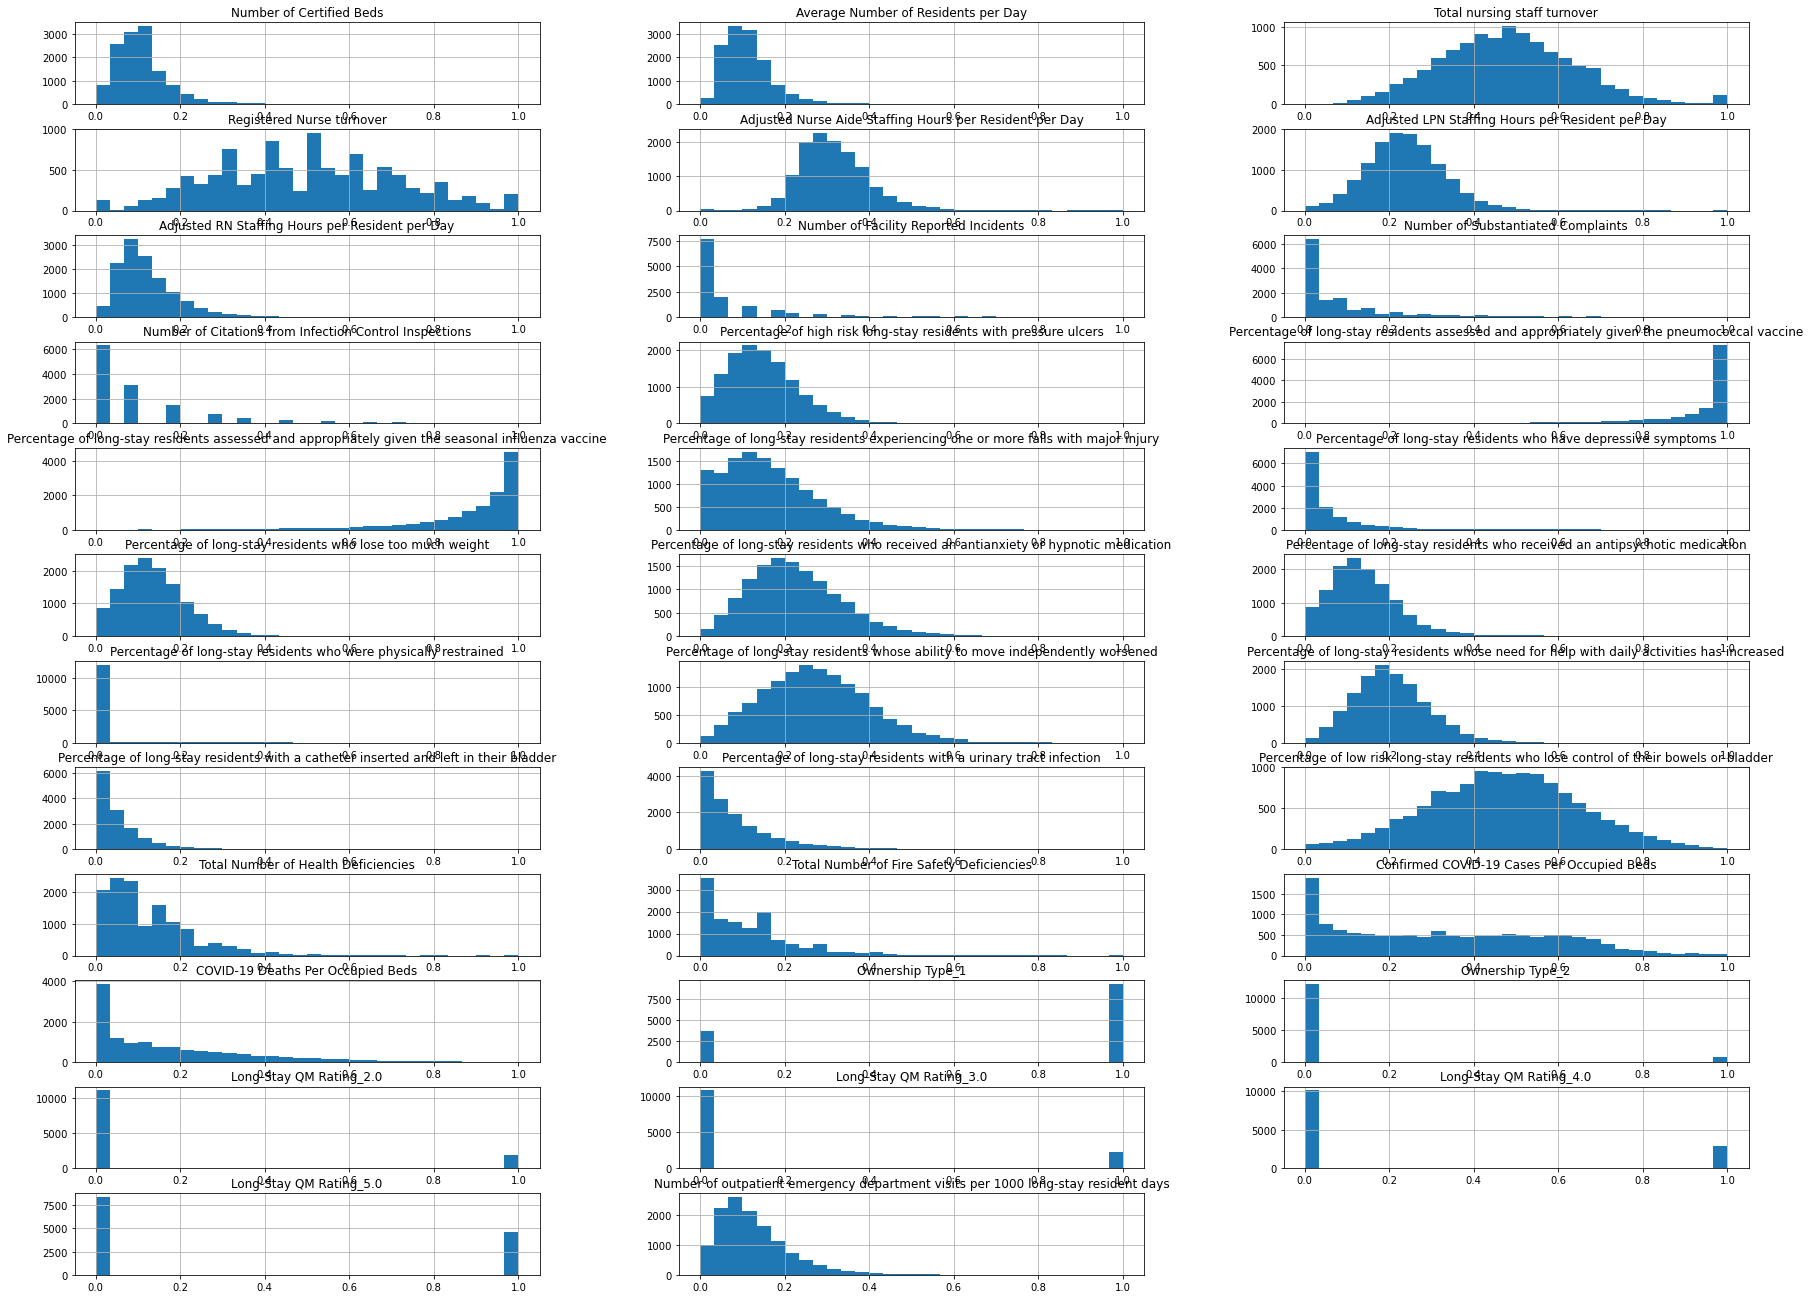

In [305]:
# Visualize distributions
normalized_df.hist(bins=30, figsize=(30,25), layout=(13,3));

As stated above, ~15 plots are approximately normally distributed, however a number of attributes are not normally distributed or have notably long right- or left-tails. The variables that are not normally distributed will be log transformed to try to address skew.

### Log Transformation of independent variables

In [349]:
#Identify and transform non-normal columns 
normalized_df[['Number of Facility Reported Incidents', 
         'Number of Substantiated Complaints',
         'Number of Citations from Infection Control Inspections',
         'Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine',
         'Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine',
         'Percentage of long-stay residents who have depressive symptoms',
         'Percentage of long-stay residents who were physically restrained',
         'Percentage of long-stay residents with a catheter inserted and left in their bladder',
         'Percentage of long-stay residents with a urinary tract infection',
         'Total Number of Health Deficiencies',
         'Total Number of Fire Safety Deficiencies',
         'Confirmed COVID-19 Cases Per Occupied Beds',
         'COVID-19 Deaths Per Occupied Beds']] = normalized_df[['Number of Facility Reported Incidents', 
         'Number of Substantiated Complaints',
         'Number of Citations from Infection Control Inspections',
         'Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine',
         'Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine',
         'Percentage of long-stay residents who have depressive symptoms',
         'Percentage of long-stay residents who were physically restrained',
         'Percentage of long-stay residents with a catheter inserted and left in their bladder',
         'Percentage of long-stay residents with a urinary tract infection',
         'Total Number of Health Deficiencies',
         'Total Number of Fire Safety Deficiencies',
         'Confirmed COVID-19 Cases Per Occupied Beds',
         'COVID-19 Deaths Per Occupied Beds']].applymap(lambda x: np.log(1+x))

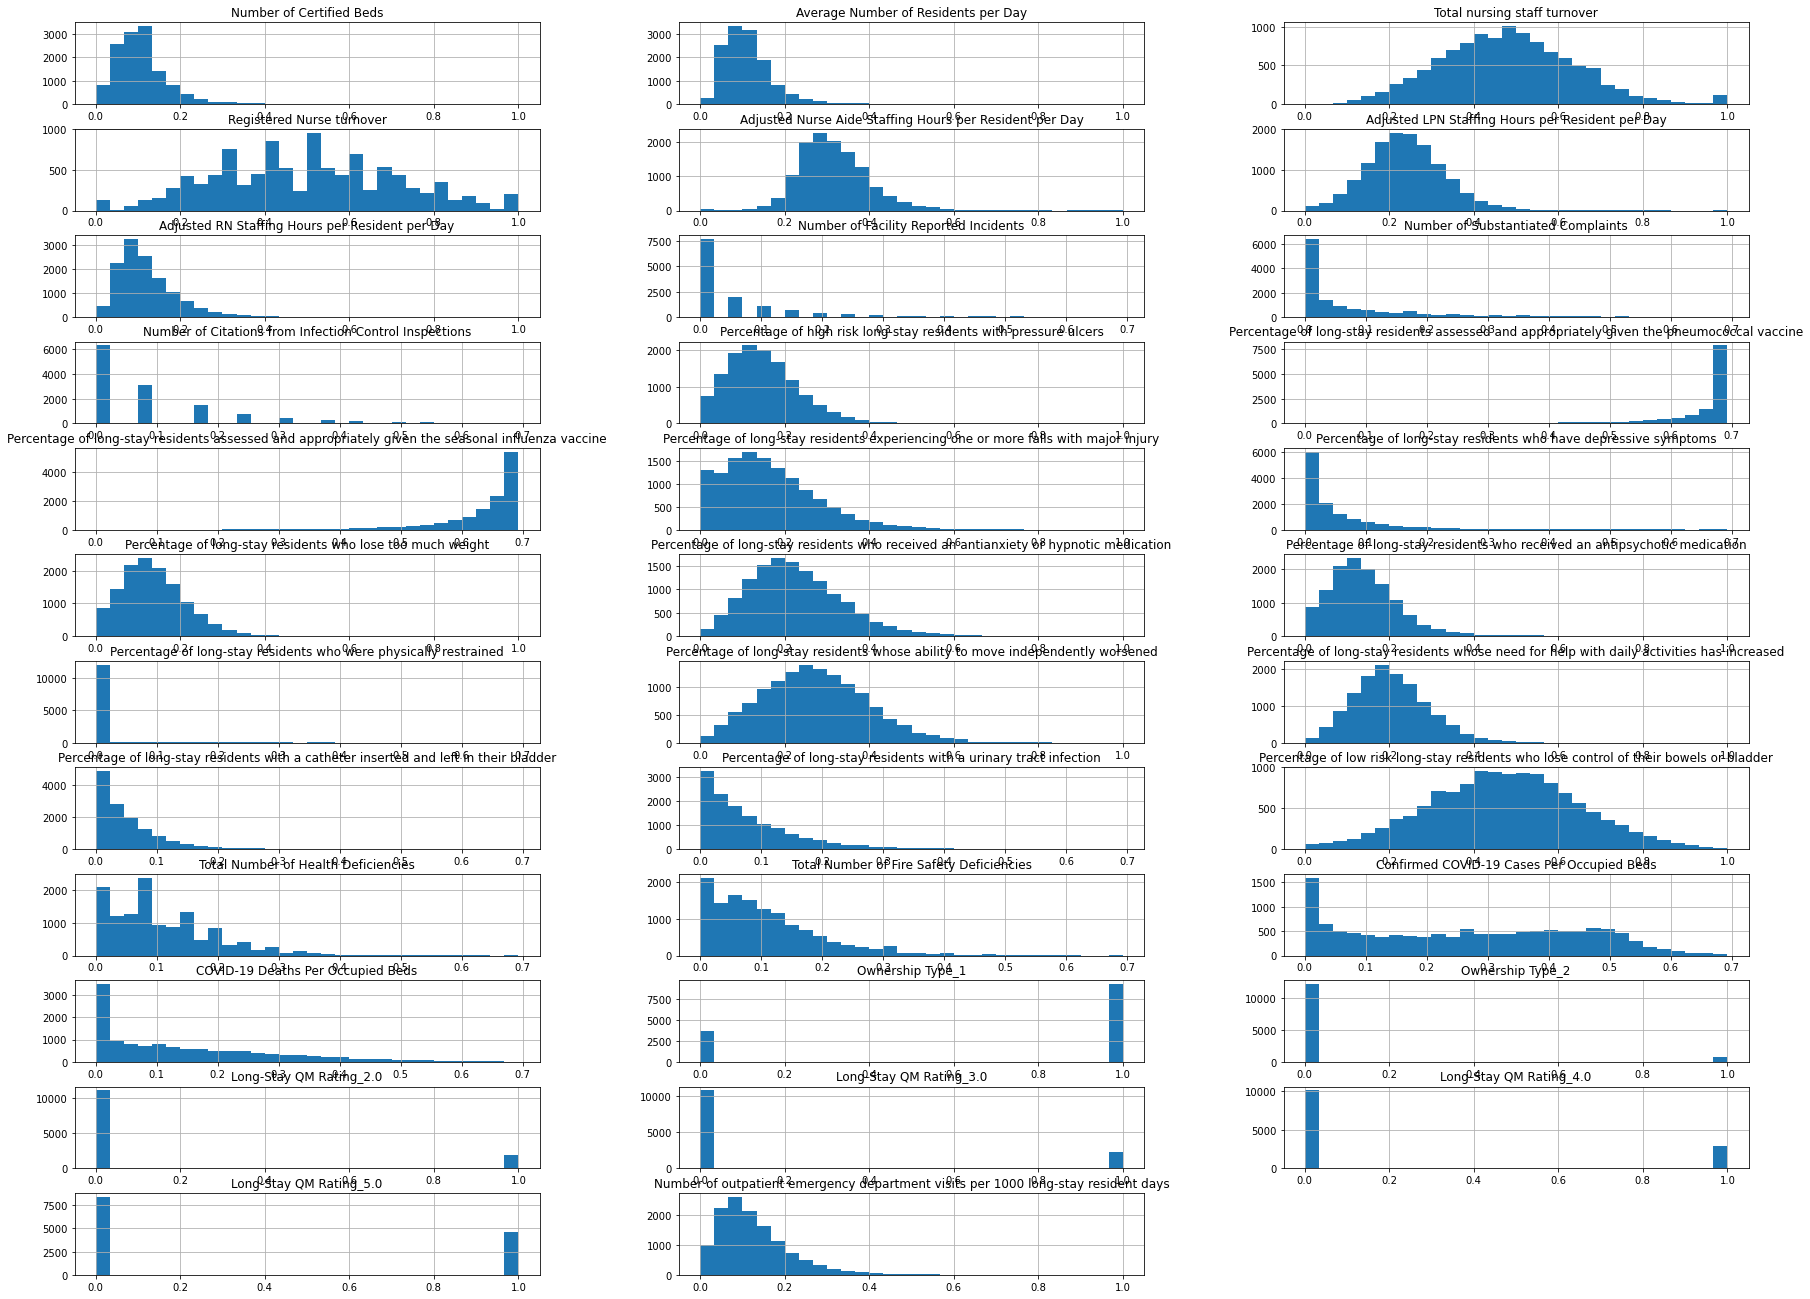

In [307]:
#Check distributions of transformed data set
normalized_df.hist(bins=30, figsize=(30,25), layout=(13,3));

After transformation, distributions remain non-normal for multiple attributes.

## Linearity 

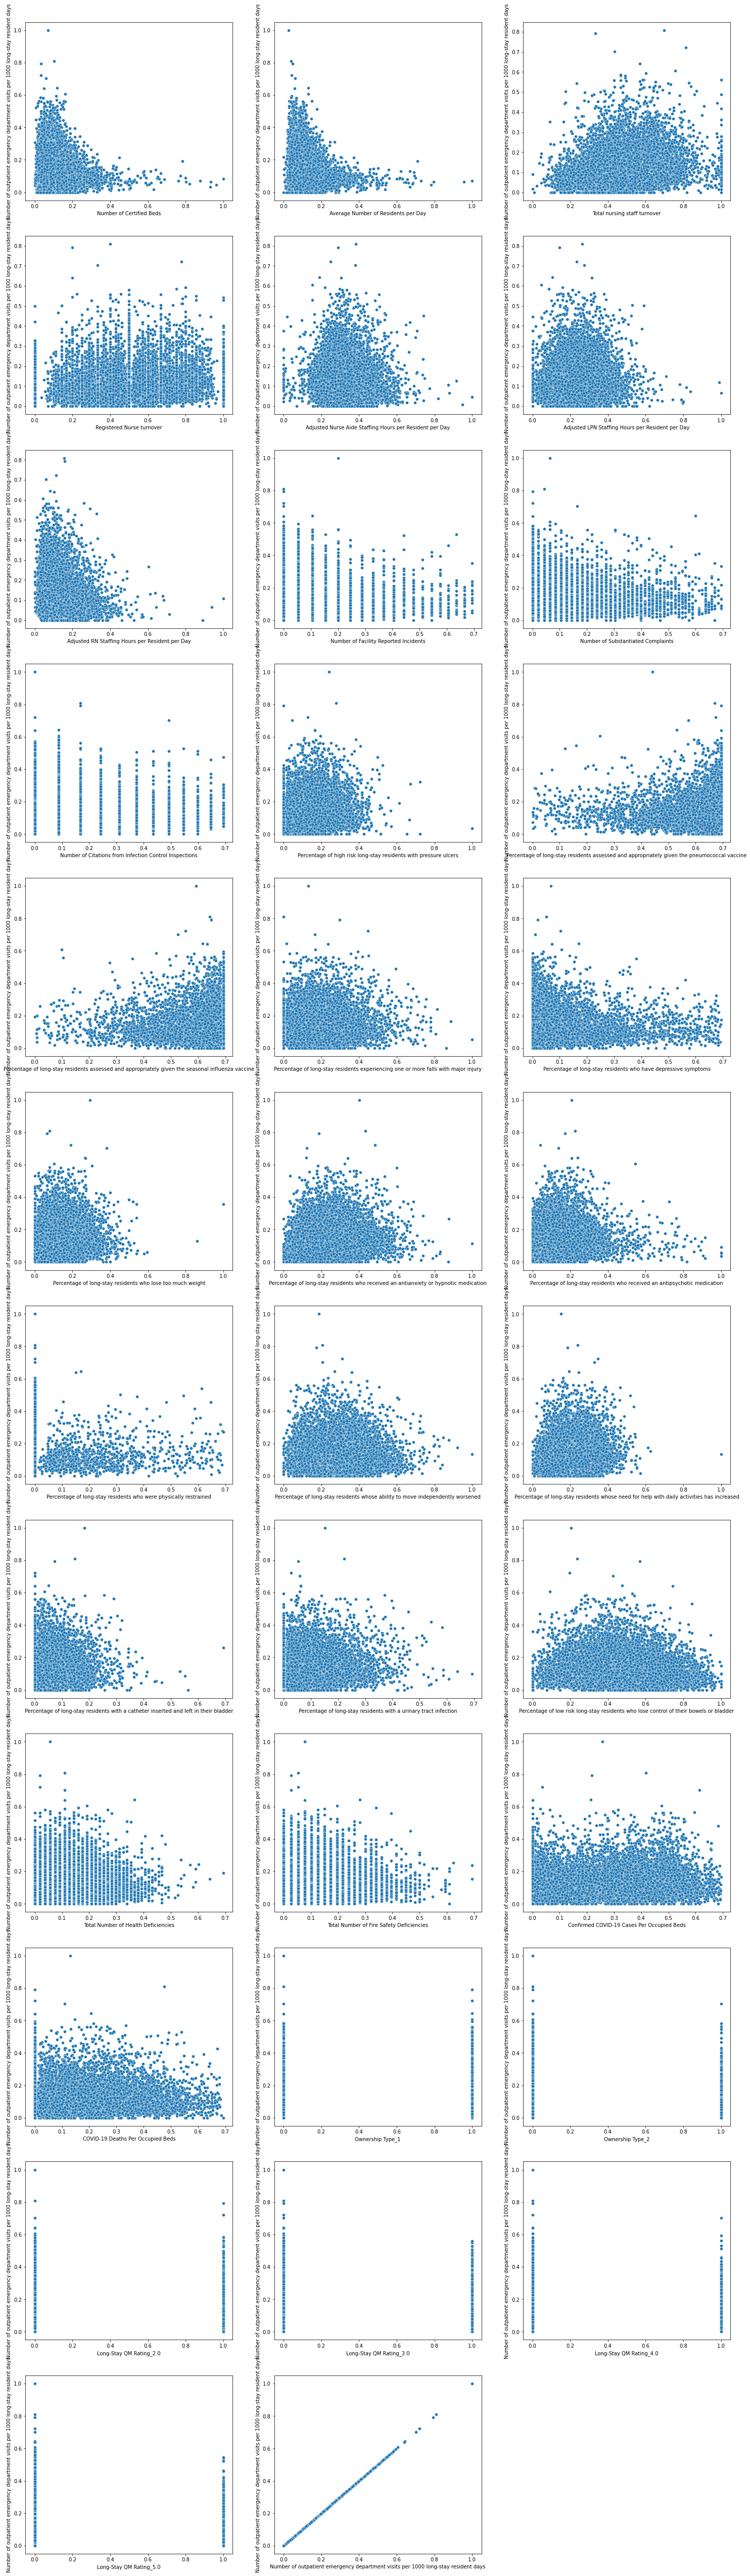

In [350]:
# Plotting independent vs dependent variables to view relationship 
count=1
plt.subplots(figsize=(25,100))
for i in normalized_df.columns:
    plt.subplot(13,3,count)
    sns.scatterplot(y=normalized_df['Number of outpatient emergency department visits per 1000 long-stay resident days'],x=normalized_df[i])
    count+=1
plt.show()

On visual inspection, linearity between the dependent variable and the independent variables does not exist for any attribute.

In [351]:
#Checking linearity between the independent and dependent variables using Pearson's coefficient
normalized_df.corr()['Number of outpatient emergency department visits per 1000 long-stay resident days']

Number of Certified Beds                                                                            -0.125236
Average Number of Residents per Day                                                                 -0.189076
Total nursing staff turnover                                                                         0.196617
Registered Nurse turnover                                                                            0.136190
Adjusted Nurse Aide Staffing Hours per Resident per Day                                             -0.026672
Adjusted LPN Staffing Hours per Resident per Day                                                     0.007379
Adjusted RN Staffing Hours per Resident per Day                                                     -0.147622
Number of Facility Reported Incidents                                                               -0.001837
Number of Substantiated Complaints                                                                   0.049065
Number of 

Examination of Pearson's coefficient against the dependent variable confirms a general lack of linearity in the model.<br>
Based on this, it could be stated that the Assumption of Linearity is not fulfilled and that the regression model may not be able to efficiently explain the data.

## Multicollinearity

In [352]:
corr = normalized_df.corr()
corr

Number of Certified Beds  \
Number of Certified Beds                                            1.000000   
Average Number of Residents per Day                                 0.900118   
Total nursing staff turnover                                       -0.126293   
Registered Nurse turnover                                          -0.021561   
Adjusted Nurse Aide Staffing Hours per Resident...                 -0.147186   
Adjusted LPN Staffing Hours per Resident per Day                   -0.004918   
Adjusted RN Staffing Hours per Resident per Day                    -0.179360   
Number of Facility Reported Incidents                               0.082669   
Number of Substantiated Complaints                                  0.179964   
Number of Citations from Infection Control Insp...                  0.112459   
Percentage of high risk long-stay residents wit...                  0.115988   
Percentage of long-stay residents assessed and ...                 -0.093494   
Percentage of long-stay residents assessed and ...                 -0.049439   
Percentage of long-stay residents experiencing ...                 -0.158051   
Percentage of long-stay residents who have depr...                  0.044107   
Percentage of long-stay residents who lose too ...                  0.016254   
Percentage of long-stay residents who received ...                 -0.071126   
Percentage of long-stay residents who received ...                 -0.029395   
Percentage of long-stay residents who were phys...                  0.032958   
Percentage of long-stay residents whose ability...                 -0.020046   
Percentage of long-stay residents whose need fo...                 -0.039799   
Percentage of long-stay residents with a cathet...                 -0.096021   
Percentage of long-stay residents with a urinar...                 -0.137161   
Percentage of low risk long-stay residents who ...                  0.034256   
Total Number of Health Deficiencies                                 0.085511   
Total Number of Fire Safety Deficiencies                            0.021074   
Confirmed COVID-19 Cases Per Occupied Beds                          0.008008   
COVID-19 Deaths Per Occupied Beds                                   0.042697   
Ownership Type_1                                                    0.055226   
Ownership Type_2                                                    0.024342   
Long-Stay QM Rating_2.0                                            -0.052735   
Long-Stay QM Rating_3.0                                            -0.014243   
Long-Stay QM Rating_4.0                                            -0.000956   
Long-Stay QM Rating_5.0                                             0.084292   
Number of outpatient emergency department visit...                 -0.125236   

                                                    Average Number of Residents per Day  \
Number of Certified Beds                                                       0.900118   
Average Number of Residents per Day                                            1.000000   
Total nursing staff turnover                                                  -0.191872   
Registered Nurse turnover                                                     -0.062282   
Adjusted Nurse Aide Staffing Hours per Resident...                            -0.144181   
Adjusted LPN Staffing Hours per Resident per Day                              -0.051727   
Adjusted RN Staffing Hours per Resident per Day                               -0.184889   
Number of Facility Reported Incidents                                          0.075109   
Number of Substantiated Complaints                                             0.134916   
Number of Citations from Infection Control Insp...                             0.075274   
Percentage of high risk long-stay residents wit...                             0.087770   
Percentage of long-stay residents assessed and ...                            -

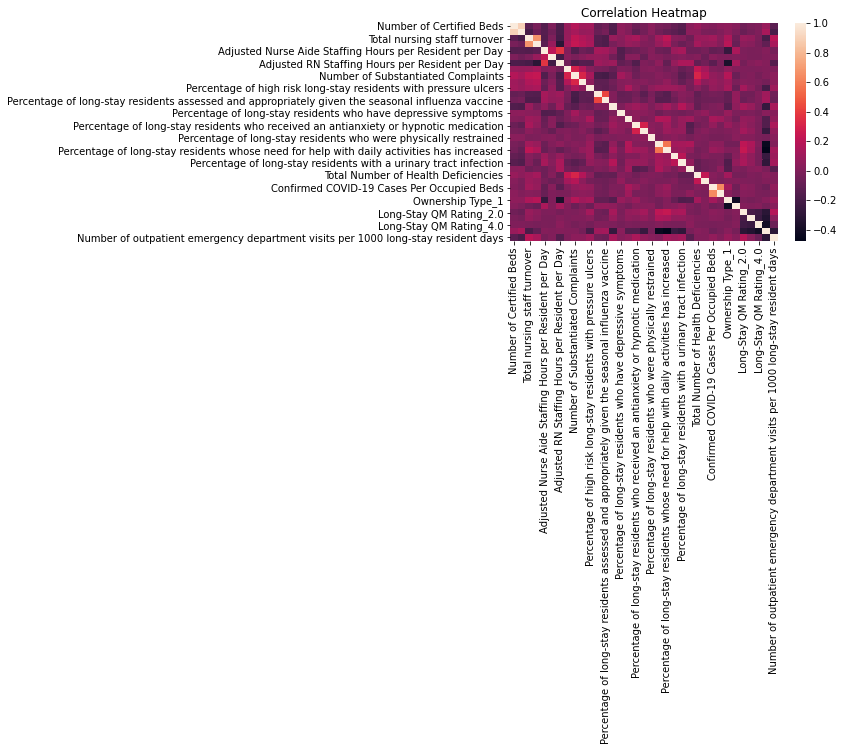

In [353]:
corr2 = sns.heatmap(corr).set_title('Correlation Heatmap')
figure = corr2.get_figure()

Most attributes are not correlated or weakly correlated. <br>
Number of Certified Beds and Average Number of Residents per Day are the only attributes that were strongly correlated > 0.9. <br>
Additionally, it is suspected that the dummy variables of Ownership Type and Long-Stay QM are highly correlated within themselves. <br>
Registered Nurse turnover and Total nursing staff turnover, COVID-19 deaths per occupied beds and confirmed COVID-19 cases per occupied beds, and Percentage of long-stay residents whose need for help with daily activities has increased and Percentage of long-stay residents whose ability to move independently worsened were moderately correlated at 0.67, 0.64 and 0.57 respectively.
This will be checked through VIF. 

In [359]:
#VIF testing
temp_df = normalized_df.copy()
temp_df = temp_df.dropna() #Removing NaNs for regression
x = temp_df.drop(['Number of outpatient emergency department visits per 1000 long-stay resident days'], axis=1)
y = temp_df['Number of outpatient emergency department visits per 1000 long-stay resident days']
X = sm.add_constant(x)

In [360]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif = pd.DataFrame()
vif["VIF Factor"] = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
vif

VIF Factor
const                                               248.075254
Number of Certified Beds                              5.851478
Average Number of Residents per Day                   6.123436
Total nursing staff turnover                          2.109533
Registered Nurse turnover                             2.020053
Adjusted Nurse Aide Staffing Hours per Resident...    1.406772
Adjusted LPN Staffing Hours per Resident per Day      1.268263
Adjusted RN Staffing Hours per Resident per Day       1.787931
Number of Facility Reported Incidents                 1.167536
Number of Substantiated Complaints                    1.450225
Number of Citations from Infection Control Insp...    1.174784
Percentage of high risk long-stay residents wit...    1.217916
Percentage of long-stay residents assessed and ...    1.291862
Percentage of long-stay residents assessed and ...    1.291086
Percentage of long-stay residents experiencing ...    1.236873
Percentage of long-stay residents who have depr...    1.091231
Percentage of long-stay residents who lose too ...    1.104784
Percentage of long-stay residents who received ...    1.210473
Percentage of long-stay residents who received ...    1.275841
Percentage of long-stay residents who were phys...    1.014942
Percentage of long-stay residents whose ability...    1.737497
Percentage of long-stay residents whose need fo...    1.839813
Percentage of long-stay residents with a cathet...    1.174875
Percentage of long-stay residents with a urinar...    1.283787
Percentage of low risk long-stay residents who ...    1.138879
Total Number of Health Deficiencies                   1.209147
Total Number of Fire Safety Deficiencies              1.101103
Confirmed COVID-19 Cases Per Occupied Beds            1.804300
COVID-19 Deaths Per Occupied Beds                     1.741116
Ownership Type_1                                      1.490201
Ownership Type_2                                      1.229458
Long-Stay QM Rating_2.0                               2.414610
Long-Stay QM Rating_3.0                               2.935501
Long-Stay QM Rating_4.0                               3.871905
Long-Stay QM Rating_5.0                               6.649661

Based on the VIF estimation of multicollinearity < 5, most variables are not correlated or mildly correlated. As previously established, Number of Certified Beds and Average Number of Residents per Stay are highly correlated. Therefore, Number of Certified Beds will be dropped from the dataset. Additionally, one of the dummy variable attributes will be dropped for Long-Stay QM Rating.

In [361]:
#Drop Average Number of Residents per Day and Long-Stay QM Rating 5.0 then rerun VIF to validate
X.drop(['Average Number of Residents per Day','Long-Stay QM Rating_5.0'], axis=1, inplace=True)
X.head()

const  Number of Certified Beds  Total nursing staff turnover  \
1    1.0                  0.078271                      0.493078   
4    1.0                  0.099299                      0.481363   
5    1.0                  0.153037                      0.542066   
6    1.0                  0.123832                      0.603834   
7    1.0                  0.213785                      0.467519   

   Registered Nurse turnover  \
1                      0.214   
4                      0.600   
5                      0.526   
6                      0.455   
7                      0.304   

   Adjusted Nurse Aide Staffing Hours per Resident per Day  \
1                                           0.361495         
4                                           0.342242         
5                                           0.282569         
6                                           0.312340         
7                                           0.255430         

   Adjusted LPN Staffing Hours per Resident per Day  \
1                                          0.228712   
4                                          0.352037   
5                                          0.172974   
6                                          0.287205   
7                                          0.252033   

   Adjusted RN Staffing Hours per Resident per Day  \
1                                         0.211119   
4                                         0.090386   
5                                         0.141020   
6                                         0.099010   
7                                         0.202897   

   Number of Facility Reported Incidents  Number of Substantiated Complaints  \
1                               0.000000                            0.000000   
4                               0.000000                            0.021979   
5                               0.154151                            0.064539   
6                               0.000000                            0.085158   
7                               0.105361                            0.000000   

   Number of Citations from Infection Control Inspections  ...  \
1                                                0.0       ...   
4                                                0.0       ...   
5                                                0.0       ...   
6                                                0.0       ...   
7                                                0.0       ...   

   Percentage of low risk long-stay residents who lose control of their bowels or bladder  \
1                                           0.428571                                        
4                                           0.323232                                        
5                                           0.430464                                        
6                                           0.025641                                        
7                                           0.843750                                        

   Total Number of Health Deficiencies  \
1                             0.126294   
4                             0.126294   
5                             0.037740   
6                             0.056089   
7                             0.074108   

   Total Number of Fire Safety Deficiencies  \
1                                  0.077962   
4                                  0.102654   
5                                  0.173272   
6                                  0.102654   
7                                  0.126752   

   Confirmed COVID-19 Cases Per Occupied Beds  \
1                                    0.169092   
4                                    0.090380   
5                                    0.324167   
6                                    0.461660   
7                                    0.491219   

   COVID-19 Deaths Per Occupied Beds  Ownership Type_1  Ownership Type_2  \
1                           

In [362]:
#Rerunning VIF
vif = pd.DataFrame()
vif["VIF Factor"] = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
vif

VIF Factor
const                                               181.539388
Number of Certified Beds                              1.188061
Total nursing staff turnover                          2.069516
Registered Nurse turnover                             2.019926
Adjusted Nurse Aide Staffing Hours per Resident...    1.402774
Adjusted LPN Staffing Hours per Resident per Day      1.242929
Adjusted RN Staffing Hours per Resident per Day       1.725415
Number of Facility Reported Incidents                 1.166257
Number of Substantiated Complaints                    1.448905
Number of Citations from Infection Control Insp...    1.174431
Percentage of high risk long-stay residents wit...    1.147161
Percentage of long-stay residents assessed and ...    1.291123
Percentage of long-stay residents assessed and ...    1.290828
Percentage of long-stay residents experiencing ...    1.154254
Percentage of long-stay residents who have depr...    1.090961
Percentage of long-stay residents who lose too ...    1.100642
Percentage of long-stay residents who received ...    1.203724
Percentage of long-stay residents who received ...    1.162491
Percentage of long-stay residents who were phys...    1.014872
Percentage of long-stay residents whose ability...    1.644525
Percentage of long-stay residents whose need fo...    1.660690
Percentage of long-stay residents with a cathet...    1.105768
Percentage of long-stay residents with a urinar...    1.195585
Percentage of low risk long-stay residents who ...    1.131526
Total Number of Health Deficiencies                   1.204523
Total Number of Fire Safety Deficiencies              1.095272
Confirmed COVID-19 Cases Per Occupied Beds            1.802064
COVID-19 Deaths Per Occupied Beds                     1.734126
Ownership Type_1                                      1.489551
Ownership Type_2                                      1.226660
Long-Stay QM Rating_2.0                               1.410422
Long-Stay QM Rating_3.0                               1.305784
Long-Stay QM Rating_4.0                               1.213829

Utilizing a VIF indicator of multicollinearity <5, it can be stated that the assumption of reducing multicollinearity is satisfied with the following attributes dropped: 
'Number of Certified Beds', 'Long-Stay QM Rating_5.0'. 

In [365]:
new_df = normalized_df.drop(['Average Number of Residents per Day', 'Long-Stay QM Rating_5.0'], axis=1)
new_df

Number of Certified Beds  Total nursing staff turnover  \
0                      0.045561                           NaN   
1                      0.078271                      0.493078   
2                      0.037383                           NaN   
3                      0.086449                           NaN   
4                      0.099299                      0.481363   
...                         ...                           ...   
15216                  0.130841                           NaN   
15217                  0.123832                      0.282215   
15225                  0.084112                           NaN   
15234                  0.154206                           NaN   
15235                  0.216121                      0.322684   

       Registered Nurse turnover  \
0                            NaN   
1                          0.214   
2                            NaN   
3                            NaN   
4                          0.600   
...                          ...   
15216                        NaN   
15217                      0.400   
15225                        NaN   
15234                        NaN   
15235                      0.452   

       Adjusted Nurse Aide Staffing Hours per Resident per Day  \
0                                                    NaN         
1                                               0.361495         
2                                                    NaN         
3                                               0.293437         
4                                               0.342242         
...                                                  ...         
15216                                                NaN         
15217                                           0.243657         
15225                                                NaN         
15234                                           0.343166         
15235                                           0.368791         

       Adjusted LPN Staffing Hours per Resident per Day  \
0                                                   NaN   
1                                              0.228712   
2                                                   NaN   
3                                              0.271050   
4                                              0.352037   
...                                                 ...   
15216                                               NaN   
15217                                          0.227983   
15225                                               NaN   
15234                                          0.116700   
15235                                          0.104998   

       Adjusted RN Staffing Hours per Resident per Day  \
0                                                  NaN   
1                                             0.211119   
2                                                  NaN   
3                                             0.096056   
4                                             0.090386   
...                                                ...   
15216                                              NaN   
15217                                         0.030282   
15225                                              NaN   
15234                                         0.243270   
15235                                         0.202933   

       Number of Facility Reported Incidents  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                                   0.000000   
4                                   0.000000   
...                                      ...   
15216                               0.000000   
15217                               0.200671   
15225                               0.000000   
15234                               0.000000   
15235                               0.000000   

       Number of 

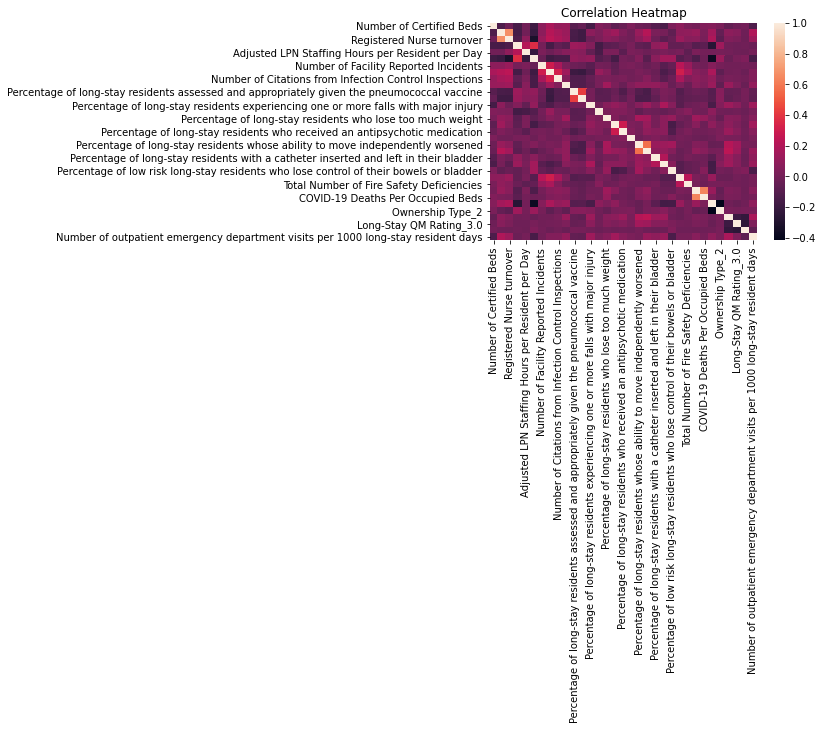

In [366]:
post_corr = new_df.corr()
post_corr = sns.heatmap(post_corr).set_title('Correlation Heatmap')
figure = post_corr.get_figure()

## Normality of Error terms

In [367]:
# Create model for testing distribution of errors
temp_df = new_df.copy()
temp_df = temp_df.dropna() #Removing NaNs for regression
x = temp_df.drop(['Number of outpatient emergency department visits per 1000 long-stay resident days'], axis=1)
y = temp_df['Number of outpatient emergency department visits per 1000 long-stay resident days']
X = sm.add_constant(x)
model = sm.OLS(y, X, missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.142
Model:                                                                                           OLS   Adj. R-squared:                  0.140
Method:                                                                                Least Squares   F-statistic:                     51.55
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          1.80e-301
Time:                                                                                       15:39:50   Log-Likelihood:                 11344.
No. Observations:                                                                               9977   AIC:                        -2.262e+04
Df Residuals:                                                                                   9944   BIC:                        -2.238e+04
Df Model:                                                                                         32                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1134      0.010     10.808      0.000       0.093       0.134
Number of Certified Beds                                                                             -0.1299      0.012    -10.901      0.000      -0.153      -0.107
Total nursing staff turnover                                                                          0.0485      0.007      6.900      0.000       0.035       0.062
Registered Nurse turnover                                                                             0.0026      0.005      0.492      0.623      -0.008       0.013
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0209      0.012      1.805      0.071      -0.002       0.044
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0276      0.010     -2.858      0.004      -0.046      -0.009
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1203      0.014     -8.299      0.000      -0.149      -0.092
Number of Facility Reported Incidents                                                                 0.0020      0.007      0.276      0.783      -0.012       0.017
Number of Substantiated Complaints                                                                    0.0129      0.008      1.666      0.096      -0.002       0.028
Number of Citations from Infection Control Inspections                                                0.0068      0.006      1.054      0.292      -0.006       0.020
Percentage of high risk long-stay residents with pressure ulcers                                      0.0544      0.010      5.274      0.000       0.034       0.075
Percentage of long-stay residents assessed and appropriately given

Based on preliminary analysis of the regression model, some general observations can be made: 
- R^2 = 0.142, which is relatively low 
- There are multiple measures with a p-value > 0.05

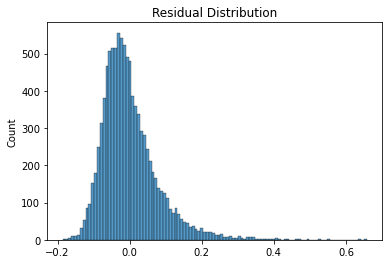

In [368]:
#Visual analysis 
#Create histogram of errors/residuals
sns.histplot(model.resid).set_title('Residual Distribution');

On visual analysis, model residuals seem approximately normal in distribution, with some right skew.

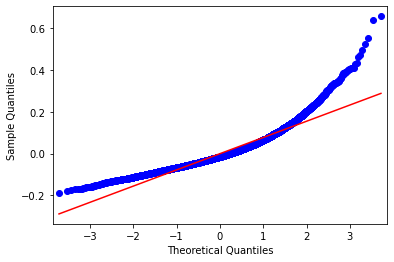

In [369]:
#Create qqplot of residuals 
sm.qqplot(model.resid, line='s');

The qq-plot additionally shows the right-skew.

In [370]:
#Using the Jarque-Bera test to confirm lack of normality in residuals 
stats.jarque_bera(model.resid)

Jarque_beraResult(statistic=12396.13265371904, pvalue=0.0)

The Jarque-Bera test is significant for a test statistic of 12396 which confirms that the model residuals have enough skewness and kurtosis to be signficiantly different from a normal distribution. Thus, the model fails this assumption.

## Autocorrelation of Error Terms

In [371]:
#Testing for autocorrelation of model residuals using Durbin-Watson test 
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model.resid)

1.8704569070090407

Durbin-Watson test to test autocorrelation of error terms/residuals = 1.87, showing little to no autocorrelation in the model. The errors are independent within the model.

## Homoscedasticity

In [372]:
#Testing for homoscedasticity using the Het-Breuschpagan Test
import statsmodels.stats.api as sms
test = sms.het_breuschpagan(model.resid, model.model.exog)
test

(315.1530152787264,
 2.8470343478614106e-48,
 10.1361364605268,
 3.6968662056116645e-49)

Based on the Breusch-Pagan test (where value 1 is the Lagrange multiplier statistic, and value 2 is the p-value), heteroscedasticity is present within the model. Thus, the residuals are not distributed with equal variance, which means that the results of the regression analysis may not be reliable. To attempt to address this, the dependent variable will be log transformed. 

In [373]:
# Recreate model with transformed dependent variable 
temp_df = new_df.copy()
temp_df = temp_df.dropna() #Removing NaNs for regression
x_2 = temp_df.drop(['Number of outpatient emergency department visits per 1000 long-stay resident days'], axis=1)
y_2 = temp_df[['Number of outpatient emergency department visits per 1000 long-stay resident days']].applymap(lambda x: np.log(1+x))
Z = sm.add_constant(x_2)
model_2 = sm.OLS(y_2, Z, missing='drop').fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.145
Method:                                                                                Least Squares   F-statistic:                     54.06
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          3.60e-316
Time:                                                                                       15:40:52   Log-Likelihood:                 13014.
No. Observations:                                                                               9977   AIC:                        -2.596e+04
Df Residuals:                                                                                   9944   BIC:                        -2.572e+04
Df Model:                                                                                         32                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1050      0.009     11.834      0.000       0.088       0.122
Number of Certified Beds                                                                             -0.1091      0.010    -10.819      0.000      -0.129      -0.089
Total nursing staff turnover                                                                          0.0419      0.006      7.050      0.000       0.030       0.054
Registered Nurse turnover                                                                             0.0026      0.004      0.578      0.563      -0.006       0.011
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0165      0.010      1.680      0.093      -0.003       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0230      0.008     -2.823      0.005      -0.039      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1050      0.012     -8.560      0.000      -0.129      -0.081
Number of Facility Reported Incidents                                                                 0.0025      0.006      0.395      0.693      -0.010       0.015
Number of Substantiated Complaints                                                                    0.0112      0.007      1.705      0.088      -0.002       0.024
Number of Citations from Infection Control Inspections                                                0.0058      0.005      1.053      0.292      -0.005       0.016
Percentage of high risk long-stay residents with pressure ulcers                                      0.0463      0.009      5.305      0.000       0.029       0.063
Percentage of long-stay residents assessed and appropriately given

In [374]:
test = sms.het_breuschpagan(model_2.resid, model.model.exog)
test

(349.72090216883,
 4.184508263759487e-55,
 11.28831617371998,
 3.1770504987141606e-56)

Based on the redone Breusch-Pagan test (where value 1 is the Lagrange multiplier statistic, and value 2 is the p-value), heteroscedasticity continues to be present within the model. Thus, the residuals remain not distributed with equal variance, which means that the results of the regression analysis may not be reliable.

<b>Assumption testing summary:</b> <br>
    - Normality of predictor distributions: failed after log transformation of predicator variables <br>
    - Linearity of independent and dependant variables: failed <br>
    - Mullicolinearity: Passed after removing attributes with high correlation using VIF <br>
    - Normality of error terms: Failed due to right shew of error terms<br>
    - Autocorrelation of error terms: Passed based on the Durbin-Watson test<br>
    - Homoscedasticity: Failed based on the Breusch-Pagan test<br>
The results of assumption testing show that linear regression may not be the ideal test to use for this dataset. Regardless, linear regression will be conducted on the data and the effect of the failed assumptions will be considered in context of the performance of the model.

# Model Building 

In [375]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.145
Method:                                                                                Least Squares   F-statistic:                     54.06
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          3.60e-316
Time:                                                                                       15:41:13   Log-Likelihood:                 13014.
No. Observations:                                                                               9977   AIC:                        -2.596e+04
Df Residuals:                                                                                   9944   BIC:                        -2.572e+04
Df Model:                                                                                         32                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1050      0.009     11.834      0.000       0.088       0.122
Number of Certified Beds                                                                             -0.1091      0.010    -10.819      0.000      -0.129      -0.089
Total nursing staff turnover                                                                          0.0419      0.006      7.050      0.000       0.030       0.054
Registered Nurse turnover                                                                             0.0026      0.004      0.578      0.563      -0.006       0.011
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0165      0.010      1.680      0.093      -0.003       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0230      0.008     -2.823      0.005      -0.039      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1050      0.012     -8.560      0.000      -0.129      -0.081
Number of Facility Reported Incidents                                                                 0.0025      0.006      0.395      0.693      -0.010       0.015
Number of Substantiated Complaints                                                                    0.0112      0.007      1.705      0.088      -0.002       0.024
Number of Citations from Infection Control Inspections                                                0.0058      0.005      1.053      0.292      -0.005       0.016
Percentage of high risk long-stay residents with pressure ulcers                                      0.0463      0.009      5.305      0.000       0.029       0.063
Percentage of long-stay residents assessed and appropriately given

Note the following general observations: <br>
- R^2 = 0.148
- F-value is statistically significant
- There are multiple measures with a p-value > 0.05

Stepwise regression will be performed to increase stability of the model. Alpha = 0.05 so coefficients with p-value > 0.05 will be removed.

In [376]:
#Performing stepwise regression on largest p-value attribute
#Removing 'Percentage of long-stay residents who have depressive symptoms'
Z_drop = Z.drop(['Percentage of long-stay residents who have depressive symptoms'], axis=1)
model_3 = sm.OLS(y_2, Z_drop, missing='drop').fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     55.81
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          4.78e-317
Time:                                                                                       15:42:03   Log-Likelihood:                 13014.
No. Observations:                                                                               9977   AIC:                        -2.596e+04
Df Residuals:                                                                                   9945   BIC:                        -2.573e+04
Df Model:                                                                                         31                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1050      0.009     12.003      0.000       0.088       0.122
Number of Certified Beds                                                                             -0.1091      0.010    -10.819      0.000      -0.129      -0.089
Total nursing staff turnover                                                                          0.0419      0.006      7.050      0.000       0.030       0.054
Registered Nurse turnover                                                                             0.0026      0.004      0.578      0.564      -0.006       0.011
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0165      0.010      1.682      0.093      -0.003       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0231      0.008     -2.852      0.004      -0.039      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1050      0.012     -8.591      0.000      -0.129      -0.081
Number of Facility Reported Incidents                                                                 0.0025      0.006      0.394      0.694      -0.010       0.015
Number of Substantiated Complaints                                                                    0.0112      0.007      1.714      0.087      -0.002       0.024
Number of Citations from Infection Control Inspections                                                0.0058      0.005      1.053      0.292      -0.005       0.016
Percentage of high risk long-stay residents with pressure ulcers                                      0.0463      0.009      5.306      0.000       0.029       0.063
Percentage of long-stay residents assessed and appropriately given

In [378]:
#Removing 'Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine' 
Z_drop_1 = Z_drop.drop(['Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine'], axis=1)
model_4 = sm.OLS(y_2, Z_drop_1, missing='drop').fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     57.68
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          6.40e-318
Time:                                                                                       15:42:53   Log-Likelihood:                 13014.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9946   BIC:                        -2.574e+04
Df Model:                                                                                         30                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1042      0.008     12.922      0.000       0.088       0.120
Number of Certified Beds                                                                             -0.1089      0.010    -10.823      0.000      -0.129      -0.089
Total nursing staff turnover                                                                          0.0419      0.006      7.052      0.000       0.030       0.054
Registered Nurse turnover                                                                             0.0026      0.004      0.586      0.558      -0.006       0.011
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0164      0.010      1.674      0.094      -0.003       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0232      0.008     -2.869      0.004      -0.039      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1050      0.012     -8.595      0.000      -0.129      -0.081
Number of Facility Reported Incidents                                                                 0.0024      0.006      0.385      0.700      -0.010       0.015
Number of Substantiated Complaints                                                                    0.0113      0.007      1.733      0.083      -0.001       0.024
Number of Citations from Infection Control Inspections                                                0.0058      0.005      1.059      0.290      -0.005       0.017
Percentage of high risk long-stay residents with pressure ulcers                                      0.0463      0.009      5.314      0.000       0.029       0.063
Percentage of long-stay residents assessed and appropriately given

In [379]:
#Removing 'Number of Facility Reported Incidents' 
Z_drop_2 = Z_drop_1.drop(['Number of Facility Reported Incidents'], axis=1)
model_5 = sm.OLS(y_2, Z_drop_2, missing='drop').fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     59.67
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          8.84e-319
Time:                                                                                       15:43:25   Log-Likelihood:                 13014.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9947   BIC:                        -2.575e+04
Df Model:                                                                                         29                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1041      0.008     12.918      0.000       0.088       0.120
Number of Certified Beds                                                                             -0.1088      0.010    -10.817      0.000      -0.129      -0.089
Total nursing staff turnover                                                                          0.0419      0.006      7.053      0.000       0.030       0.054
Registered Nurse turnover                                                                             0.0027      0.004      0.605      0.545      -0.006       0.011
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0166      0.010      1.698      0.089      -0.003       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0231      0.008     -2.861      0.004      -0.039      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1049      0.012     -8.588      0.000      -0.129      -0.081
Number of Substantiated Complaints                                                                    0.0118      0.006      1.847      0.065      -0.001       0.024
Number of Citations from Infection Control Inspections                                                0.0060      0.005      1.092      0.275      -0.005       0.017
Percentage of high risk long-stay residents with pressure ulcers                                      0.0463      0.009      5.311      0.000       0.029       0.063
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0181      0.007     -2.424      0.015      -0.033      -0.003
Percentage of long-stay residents experiencing one or more falls w

In [380]:
#Removing 'Registered Nurse turnover' 
Z_drop_3 = Z_drop_2.drop(['Registered Nurse turnover'], axis=1)
model_6 = sm.OLS(y_2, Z_drop_3, missing='drop').fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     61.79
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          1.33e-319
Time:                                                                                       15:43:44   Log-Likelihood:                 13014.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9948   BIC:                        -2.576e+04
Df Model:                                                                                         28                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1044      0.008     12.986      0.000       0.089       0.120
Number of Certified Beds                                                                             -0.1087      0.010    -10.810      0.000      -0.128      -0.089
Total nursing staff turnover                                                                          0.0441      0.005      9.510      0.000       0.035       0.053
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0169      0.010      1.741      0.082      -0.002       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0228      0.008     -2.832      0.005      -0.039      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1061      0.012     -8.822      0.000      -0.130      -0.083
Number of Substantiated Complaints                                                                    0.0119      0.006      1.874      0.061      -0.001       0.024
Number of Citations from Infection Control Inspections                                                0.0061      0.005      1.120      0.263      -0.005       0.017
Percentage of high risk long-stay residents with pressure ulcers                                      0.0465      0.009      5.333      0.000       0.029       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0183      0.007     -2.458      0.014      -0.033      -0.004
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0652      0.006     10.422      0.000       0.053       0.077
Percentage of long-stay residents who lose too much weight        

In [381]:
#Removing 'Total Number of Fire Safety Deficiencies' 
Z_drop_4 = Z_drop_3.drop(['Total Number of Fire Safety Deficiencies'], axis=1)
model_7 = sm.OLS(y_2, Z_drop_4, missing='drop').fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     64.05
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          2.34e-320
Time:                                                                                       15:44:16   Log-Likelihood:                 13013.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9949   BIC:                        -2.577e+04
Df Model:                                                                                         27                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1038      0.008     12.963      0.000       0.088       0.120
Number of Certified Beds                                                                             -0.1088      0.010    -10.813      0.000      -0.128      -0.089
Total nursing staff turnover                                                                          0.0439      0.005      9.475      0.000       0.035       0.053
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0166      0.010      1.709      0.087      -0.002       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0223      0.008     -2.773      0.006      -0.038      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1058      0.012     -8.796      0.000      -0.129      -0.082
Number of Substantiated Complaints                                                                    0.0114      0.006      1.799      0.072      -0.001       0.024
Number of Citations from Infection Control Inspections                                                0.0063      0.005      1.153      0.249      -0.004       0.017
Percentage of high risk long-stay residents with pressure ulcers                                      0.0468      0.009      5.373      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0182      0.007     -2.443      0.015      -0.033      -0.004
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0652      0.006     10.420      0.000       0.053       0.077
Percentage of long-stay residents who lose too much weight        

In [382]:
#Removing 'Long-Stay QM Rating_4.0' 
Z_drop_5 = Z_drop_4.drop(['Long-Stay QM Rating_4.0'], axis=1)
model_8 = sm.OLS(y_2, Z_drop_5, missing='drop').fit()
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     66.48
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          4.56e-321
Time:                                                                                       15:44:43   Log-Likelihood:                 13013.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9950   BIC:                        -2.578e+04
Df Model:                                                                                         26                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1040      0.008     12.995      0.000       0.088       0.120
Number of Certified Beds                                                                             -0.1089      0.010    -10.828      0.000      -0.129      -0.089
Total nursing staff turnover                                                                          0.0439      0.005      9.483      0.000       0.035       0.053
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0165      0.010      1.694      0.090      -0.003       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0224      0.008     -2.792      0.005      -0.038      -0.007
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1056      0.012     -8.784      0.000      -0.129      -0.082
Number of Substantiated Complaints                                                                    0.0112      0.006      1.773      0.076      -0.001       0.024
Number of Citations from Infection Control Inspections                                                0.0063      0.005      1.166      0.244      -0.004       0.017
Percentage of high risk long-stay residents with pressure ulcers                                      0.0470      0.009      5.408      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0183      0.007     -2.453      0.014      -0.033      -0.004
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0656      0.006     10.492      0.000       0.053       0.078
Percentage of long-stay residents who lose too much weight        

In [383]:
#Removing 'Total Number of Health Deficiencies' 
Z_drop_6 = Z_drop_5.drop(['Total Number of Health Deficiencies'], axis=1)
model_9 = sm.OLS(y_2, Z_drop_6, missing='drop').fit()
model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     69.08
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          1.05e-321
Time:                                                                                       15:45:06   Log-Likelihood:                 13012.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9951   BIC:                        -2.578e+04
Df Model:                                                                                         25                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1051      0.008     13.210      0.000       0.089       0.121
Number of Certified Beds                                                                             -0.1087      0.010    -10.805      0.000      -0.128      -0.089
Total nursing staff turnover                                                                          0.0440      0.005      9.508      0.000       0.035       0.053
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0165      0.010      1.697      0.090      -0.003       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0221      0.008     -2.757      0.006      -0.038      -0.006
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1056      0.012     -8.785      0.000      -0.129      -0.082
Number of Substantiated Complaints                                                                    0.0129      0.006      2.097      0.036       0.001       0.025
Number of Citations from Infection Control Inspections                                                0.0068      0.005      1.258      0.209      -0.004       0.017
Percentage of high risk long-stay residents with pressure ulcers                                      0.0469      0.009      5.387      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0185      0.007     -2.482      0.013      -0.033      -0.004
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0654      0.006     10.464      0.000       0.053       0.078
Percentage of long-stay residents who lose too much weight        

In [384]:
#Removing 'Number of Citations from Infection Control Inspections' 
Z_drop_7 = Z_drop_6.drop(['Number of Citations from Infection Control Inspections'], axis=1)
model_10 = sm.OLS(y_2, Z_drop_7, missing='drop').fit()
model_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     71.89
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          2.67e-322
Time:                                                                                       15:45:26   Log-Likelihood:                 13011.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9952   BIC:                        -2.579e+04
Df Model:                                                                                         24                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1052      0.008     13.221      0.000       0.090       0.121
Number of Certified Beds                                                                             -0.1078      0.010    -10.746      0.000      -0.128      -0.088
Total nursing staff turnover                                                                          0.0445      0.005      9.657      0.000       0.035       0.054
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0168      0.010      1.728      0.084      -0.002       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0219      0.008     -2.731      0.006      -0.038      -0.006
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1062      0.012     -8.836      0.000      -0.130      -0.083
Number of Substantiated Complaints                                                                    0.0150      0.006      2.518      0.012       0.003       0.027
Percentage of high risk long-stay residents with pressure ulcers                                      0.0466      0.009      5.363      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0189      0.007     -2.530      0.011      -0.033      -0.004
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0654      0.006     10.467      0.000       0.053       0.078
Percentage of long-stay residents who lose too much weight                                            0.0177      0.009      1.955      0.051   -5.09e-05       0.035
Percentage of long-stay residents who received an antianxiety or h

In [385]:
#Removing 'Percentage of long-stay residents who received an antipsychotic medication' 
Z_drop_8 = Z_drop_7.drop(['Percentage of long-stay residents who received an antipsychotic medication'], axis=1)
model_11 = sm.OLS(y_2, Z_drop_8, missing='drop').fit()
model_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.148
Model:                                                                                           OLS   Adj. R-squared:                  0.146
Method:                                                                                Least Squares   F-statistic:                     74.93
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          7.91e-323
Time:                                                                                       15:45:51   Log-Likelihood:                 13010.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9953   BIC:                        -2.580e+04
Df Model:                                                                                         23                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1035      0.008     13.161      0.000       0.088       0.119
Number of Certified Beds                                                                             -0.1082      0.010    -10.779      0.000      -0.128      -0.088
Total nursing staff turnover                                                                          0.0446      0.005      9.683      0.000       0.036       0.054
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0168      0.010      1.724      0.085      -0.002       0.036
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0213      0.008     -2.660      0.008      -0.037      -0.006
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1066      0.012     -8.878      0.000      -0.130      -0.083
Number of Substantiated Complaints                                                                    0.0150      0.006      2.522      0.012       0.003       0.027
Percentage of high risk long-stay residents with pressure ulcers                                      0.0474      0.009      5.459      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0181      0.007     -2.432      0.015      -0.033      -0.004
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0653      0.006     10.459      0.000       0.053       0.078
Percentage of long-stay residents who lose too much weight                                            0.0178      0.009      1.966      0.049    5.51e-05       0.035
Percentage of long-stay residents who received an antianxiety or h

In [386]:
#Removing 'COVID-19 Deaths Per Occupied Beds' 
Z_drop_9 = Z_drop_8.drop(['COVID-19 Deaths Per Occupied Beds'], axis=1)
model_12 = sm.OLS(y_2, Z_drop_9, missing='drop').fit()
model_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.147
Model:                                                                                           OLS   Adj. R-squared:                  0.145
Method:                                                                                Least Squares   F-statistic:                     78.16
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          4.45e-323
Time:                                                                                       15:46:20   Log-Likelihood:                 13009.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9954   BIC:                        -2.581e+04
Df Model:                                                                                         22                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1032      0.008     13.129      0.000       0.088       0.119
Number of Certified Beds                                                                             -0.1090      0.010    -10.875      0.000      -0.129      -0.089
Total nursing staff turnover                                                                          0.0450      0.005      9.760      0.000       0.036       0.054
Adjusted Nurse Aide Staffing Hours per Resident per Day                                               0.0176      0.010      1.812      0.070      -0.001       0.037
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0215      0.008     -2.685      0.007      -0.037      -0.006
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1078      0.012     -8.990      0.000      -0.131      -0.084
Number of Substantiated Complaints                                                                    0.0149      0.006      2.511      0.012       0.003       0.027
Percentage of high risk long-stay residents with pressure ulcers                                      0.0474      0.009      5.456      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0179      0.007     -2.408      0.016      -0.032      -0.003
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0650      0.006     10.407      0.000       0.053       0.077
Percentage of long-stay residents who lose too much weight                                            0.0174      0.009      1.932      0.053      -0.000       0.035
Percentage of long-stay residents who received an antianxiety or h

In [388]:
#Removing 'Adjusted Nurse Aide Staffing Hours per Resident per Day' 
Z_drop_10 = Z_drop_9.drop(['Adjusted Nurse Aide Staffing Hours per Resident per Day'], axis=1)
model_13 = sm.OLS(y_2, Z_drop_10, missing='drop').fit()
model_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.147
Model:                                                                                           OLS   Adj. R-squared:                  0.145
Method:                                                                                Least Squares   F-statistic:                     81.71
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          2.47e-323
Time:                                                                                       15:46:47   Log-Likelihood:                 13007.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9955   BIC:                        -2.581e+04
Df Model:                                                                                         21                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1077      0.007     14.450      0.000       0.093       0.122
Number of Certified Beds                                                                             -0.1101      0.010    -11.000      0.000      -0.130      -0.090
Total nursing staff turnover                                                                          0.0446      0.005      9.687      0.000       0.036       0.054
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0174      0.008     -2.266      0.023      -0.033      -0.002
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1006      0.011     -8.890      0.000      -0.123      -0.078
Number of Substantiated Complaints                                                                    0.0146      0.006      2.450      0.014       0.003       0.026
Percentage of high risk long-stay residents with pressure ulcers                                      0.0471      0.009      5.421      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0172      0.007     -2.322      0.020      -0.032      -0.003
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0650      0.006     10.408      0.000       0.053       0.077
Percentage of long-stay residents who lose too much weight                                            0.0168      0.009      1.858      0.063      -0.001       0.034
Percentage of long-stay residents who received an antianxiety or hypnotic medication                  0.0339      0.006      5.305      0.000       0.021       0.046
Percentage of long-stay residents who were physically restrained  

In [389]:
#Removing 'Confirmed COVID-19 Cases Per Occupied Beds' 
Z_drop_11 = Z_drop_10.drop(['Confirmed COVID-19 Cases Per Occupied Beds'], axis=1)
model_14 = sm.OLS(y_2, Z_drop_11, missing='drop').fit()
model_14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.147
Model:                                                                                           OLS   Adj. R-squared:                  0.145
Method:                                                                                Least Squares   F-statistic:                     85.66
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          9.88e-324
Time:                                                                                       15:47:08   Log-Likelihood:                 13006.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9956   BIC:                        -2.582e+04
Df Model:                                                                                         20                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1089      0.007     14.666      0.000       0.094       0.123
Number of Certified Beds                                                                             -0.1103      0.010    -11.020      0.000      -0.130      -0.091
Total nursing staff turnover                                                                          0.0449      0.005      9.765      0.000       0.036       0.054
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0173      0.008     -2.242      0.025      -0.032      -0.002
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1015      0.011     -8.977      0.000      -0.124      -0.079
Number of Substantiated Complaints                                                                    0.0146      0.006      2.462      0.014       0.003       0.026
Percentage of high risk long-stay residents with pressure ulcers                                      0.0473      0.009      5.450      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0174      0.007     -2.343      0.019      -0.032      -0.003
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0648      0.006     10.383      0.000       0.053       0.077
Percentage of long-stay residents who lose too much weight                                            0.0183      0.009      2.045      0.041       0.001       0.036
Percentage of long-stay residents who received an antianxiety or hypnotic medication                  0.0344      0.006      5.376      0.000       0.022       0.047
Percentage of long-stay residents who were physically restrained  

In [405]:
# Final Model 
final_model = sm.OLS(y_2, Z_drop_11, missing='drop').fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.147
Model:                                                                                           OLS   Adj. R-squared:                  0.145
Method:                                                                                Least Squares   F-statistic:                     85.66
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          9.88e-324
Time:                                                                                       18:12:02   Log-Likelihood:                 13006.
No. Observations:                                                                               9977   AIC:                        -2.597e+04
Df Residuals:                                                                                   9956   BIC:                        -2.582e+04
Df Model:                                                                                         20                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1089      0.007     14.666      0.000       0.094       0.123
Number of Certified Beds                                                                             -0.1103      0.010    -11.020      0.000      -0.130      -0.091
Total nursing staff turnover                                                                          0.0449      0.005      9.765      0.000       0.036       0.054
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0173      0.008     -2.242      0.025      -0.032      -0.002
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1015      0.011     -8.977      0.000      -0.124      -0.079
Number of Substantiated Complaints                                                                    0.0146      0.006      2.462      0.014       0.003       0.026
Percentage of high risk long-stay residents with pressure ulcers                                      0.0473      0.009      5.450      0.000       0.030       0.064
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0174      0.007     -2.343      0.019      -0.032      -0.003
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0648      0.006     10.383      0.000       0.053       0.077
Percentage of long-stay residents who lose too much weight                                            0.0183      0.009      2.045      0.041       0.001       0.036
Percentage of long-stay residents who received an antianxiety or hypnotic medication                  0.0344      0.006      5.376      0.000       0.022       0.047
Percentage of long-stay residents who were physically restrained  

<b>Based on the final train model, the attributes with the most effect include: <br></b>
Number of Certified Beds: With a unit increase in Number of Certified Beds, there is a -0.1103 decrease in the Emergency Department Visit Rate. <br>
Adjusted RN Staffing Hours per Resident per Day: With a unit increase in the Adjusted RN Staffing Hours per Resident per Day, there is a -0.1015 decrease in the Emergency Department Visit Rate. <br>
Percentage of long-stay residents experiencing one or more falls with major injury: With a unit increase in the percentage of long-stay residents experiencing one or more falls with major injury, there is a positive increase of 0.0648 in the Emergency Department Visit Rate.<br>
Percentage of long-stay residents with a urinary tract infection: With a unit increase in the percentage of long-stay residents with a urinary tract infection, there is a positive increase of 0.0646 in the Emergency Department Visit Rate.<br>
Percentage of long-stay residents whose ability to move independently worsened: With a unit increase in the percentage of long-stay residents whose ability to move independently worsened, there is a decrease of 0.0522 in the Emergency Department Visit Rate.

In [395]:
#80-20 test/train split
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(Z_drop_11, y_2, random_state=0, test_size=0.2)

In [407]:
#Fit the resulting train model and time it 
from time import time
t0=time()
train_model = sm.OLS(y_train, X_train).fit()
print("Training time:", time()-t0, "seconds")
train_model.summary()

Training time: 0.00598454475402832 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.149
Model:                                                                                           OLS   Adj. R-squared:                  0.147
Method:                                                                                Least Squares   F-statistic:                     69.91
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):          5.20e-261
Time:                                                                                       19:41:02   Log-Likelihood:                 10401.
No. Observations:                                                                               7981   AIC:                        -2.076e+04
Df Residuals:                                                                                   7960   BIC:                        -2.061e+04
Df Model:                                                                                         20                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1042      0.008     12.640      0.000       0.088       0.120
Number of Certified Beds                                                                             -0.1131      0.011     -9.944      0.000      -0.135      -0.091
Total nursing staff turnover                                                                          0.0450      0.005      8.856      0.000       0.035       0.055
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0131      0.009     -1.522      0.128      -0.030       0.004
Adjusted RN Staffing Hours per Resident per Day                                                      -0.0930      0.012     -7.446      0.000      -0.117      -0.068
Number of Substantiated Complaints                                                                    0.0172      0.007      2.599      0.009       0.004       0.030
Percentage of high risk long-stay residents with pressure ulcers                                      0.0470      0.010      4.818      0.000       0.028       0.066
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0132      0.008     -1.599      0.110      -0.029       0.003
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0654      0.007      9.290      0.000       0.052       0.079
Percentage of long-stay residents who lose too much weight                                            0.0130      0.010      1.287      0.198      -0.007       0.033
Percentage of long-stay residents who received an antianxiety or hypnotic medication                  0.0374      0.007      5.242      0.000       0.023       0.051
Percentage of long-stay residents who were physically restrained  

# Model Testing

In [397]:
#Fit the test model 
test_model = sm.OLS(y_test, X_test).fit()
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                            OLS Regression Results                                                           
=============================================================================================================================================
Dep. Variable:     Number of outpatient emergency department visits per 1000 long-stay resident days   R-squared:                       0.147
Model:                                                                                           OLS   Adj. R-squared:                  0.139
Method:                                                                                Least Squares   F-statistic:                     17.08
Date:                                                                               Sun, 27 Mar 2022   Prob (F-statistic):           3.31e-55
Time:                                                                                       15:56:59   Log-Likelihood:                 2618.9
No. Observations:                                                                               1996   AIC:                            -5196.
Df Residuals:                                                                                   1975   BIC:                            -5078.
Df Model:                                                                                         20                                         
Covariance Type:                                                                           nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                 0.1274      0.017      7.434      0.000       0.094       0.161
Number of Certified Beds                                                                             -0.1057      0.021     -4.998      0.000      -0.147      -0.064
Total nursing staff turnover                                                                          0.0438      0.011      4.010      0.000       0.022       0.065
Adjusted LPN Staffing Hours per Resident per Day                                                     -0.0328      0.017     -1.885      0.060      -0.067       0.001
Adjusted RN Staffing Hours per Resident per Day                                                      -0.1398      0.027     -5.225      0.000      -0.192      -0.087
Number of Substantiated Complaints                                                                    0.0048      0.013      0.358      0.720      -0.022       0.031
Percentage of high risk long-stay residents with pressure ulcers                                      0.0488      0.019      2.559      0.011       0.011       0.086
Percentage of long-stay residents assessed and appropriately given the seasonal influenza vaccine    -0.0331      0.017     -1.971      0.049      -0.066      -0.000
Percentage of long-stay residents experiencing one or more falls with major injury                    0.0650      0.014      4.783      0.000       0.038       0.092
Percentage of long-stay residents who lose too much weight                                            0.0396      0.020      2.015      0.044       0.001       0.078
Percentage of long-stay residents who received an antianxiety or hypnotic medication                  0.0205      0.014      1.421      0.155      -0.008       0.049
Percentage of long-stay residents who were physically restrained  

In [398]:
t1=time()
y_pred = final_model.predict(X_test)
print("Predict time:", time()-t1, "seconds")

Predict time: 0.0009975433349609375 seconds


In [399]:
y_test = y_test.squeeze()

In [400]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df

Actual  Predicted
12645  0.083056   0.130967
14424  0.025257   0.131745
4928   0.104591   0.148385
5458   0.221801   0.122480
8011   0.070050   0.115959
...         ...        ...
8013   0.054993   0.123219
7346   0.192367   0.162514
3022   0.045119   0.096685
13971  0.090630   0.123708
12516  0.071836   0.129451

[1996 rows x 2 columns]

In [401]:
#Plotting actuals against predictions 
pred_df.sort_values(by='Actual', axis=0, ascending=True, inplace=True)
pred_df['Decile'] = pd.qcut(x=pred_df['Actual'], q=10, labels=False)
decile_means = pred_df.groupby(pred_df['Decile']).mean()

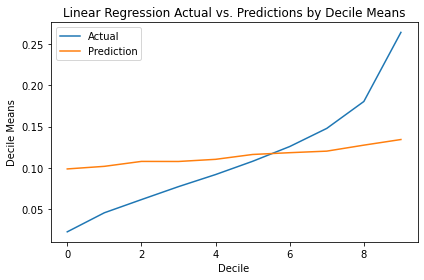

In [402]:
#Fit plot 
xax = range(len(decile_means))
plt.plot(xax, decile_means['Actual'], label='Actual')
plt.plot(xax, decile_means['Predicted'], label='Prediction')
plt.title("Linear Regression Actual vs. Predictions by Decile Means")
plt.xlabel("Decile")
plt.ylabel("Decile Means")
plt.legend()
plt.tight_layout()
plt.show()

# Model Evaluation & Validation

In [403]:
#Calculate evaluation metrics 
from sklearn import metrics
print('MAE', metrics.mean_absolute_error(y_test, y_pred))
print('R^2', metrics.r2_score(y_test, y_pred))
print('RMSE', metrics.mean_squared_error(y_test, y_pred))

MAE 0.049636849247847524
R^2 0.13804415125189162
RMSE 0.004291887533974353


Mean Absolute Error measures the accuracy of the model. A MAE of 0.045 signifies that the model is generally accurate, and closely able to predict the actual values. <br>
R^2 measures the amount of variation that can be explained by the model and currently is at 27%, which means that only 27.8% of model predictions are correct. <br>
The Root Mean Squared Error shows the spread of the residual errors. A value of 0.003 shows that the model has good performance. <br>

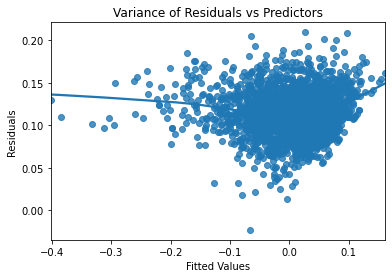

In [409]:
# Plot residuals to determine variance 
residuals = y_pred - y_test 
sns.regplot(y=y_pred, x=residuals, lowess=True)
plt.title("Variance of Residuals vs Predictors")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

Variance of the errors was generally centered around 0.